<a href="https://colab.research.google.com/github/Armand57araujo/i-tickets/blob/main/pythonnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [391]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import datetime as dt
from datetime import datetime, timedelta
# import kagglehub as k
import json
from dotenv import load_dotenv
# from urllib3.exceptions import IncompleteRead
# from tenacity import retry, stop_after_attempt, wait_exponential

imdb_movies_by_genre_df = pd.read_csv('Resources/imdb_movies_by_genre_dataset.csv')
movies_box_office_2000_to_2024_df = pd.read_csv('Resources/movies_box_office_2000_to_2024.csv')
mojo_budget_update_df = pd.read_csv('Resources/Mojo_budget_update.csv')
movies_box_office_2000_to_2024_df = pd.read_csv('Resources/movies_box_office_2000_to_2024.csv')
mojo_budget_data_df = pd.read_csv('Resources/Mojo_budget_data.csv')
movies_data_df = pd.read_csv('Resources/movies_data.csv', encoding='ISO-8859-1')

In [392]:
# load_dotenv()
# OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')



# lat, lon = 34.0522, -118.2437  # Los Angeles coordinates for example
# weather_data = []

# for date in pd.date_range("2023-01-01", "2023-01-03"):
#     unix_date = int(date.timestamp())
#     url = f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={unix_date}&appid={OPENWEATHER_API_KEY}"


#     response = requests.get(url)
#     data = response.json()
#     weather_data.append(data)

#     print(weather_data)


In [393]:


# # Load environment variables from .env file
# load_dotenv()
# OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')

# # Define the function to fetch weather data for a list of cities
# def get_weather_data(cities):
#     # Set up lists to hold response info
#     lat = []
#     lon = []
#     temp = []
#     humidity = []
#     wind = []

#     # Loop through the list of cities
#     for city in cities:
#         # Construct the API request URL for each city
#         query_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={OPENWEATHER_API_KEY}"

#         # Make the API request and get the response in JSON format
#         response = requests.get(query_url)
#         weather_json = response.json()

#         # Extract data from the API response
#         lat.append(weather_json['coord']['lat'])
#         lon.append(weather_json['coord']['lon'])
#         temp.append(weather_json['main']['temp'])
#         humidity.append(weather_json['main']['humidity'])
#         wind.append(weather_json['wind']['speed'])

#         # Print the response for debugging purposes
#         print(f"Weather data for {city}: {weather_json}")

#     # Create a DataFrame with the collected data
#     weather_dict = {
#         "city": cities,
#         "lat": lat,
#         "lon": lon,
#         "temp": temp,
#         "humidity": humidity,
#         "wind": wind,
#     }
#     weather_data = pd.DataFrame(weather_dict)
#     return weather_data

# # Define the cities list
# cities = [ "New York", "Seattle", "Los Angeles", "Chicago", "Houston", "Phoenix", "Miami"]
# #

# # Call the function and get the weather data as a DataFrame
# weather_data = get_weather_data(cities)

# # Display the weather data
# weather_data


In [394]:
# # Load environment variables from .env file
# load_dotenv()
# OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')

# # Define the function to fetch weather data for a list of cities and a date range
# def get_weather_data(cities, start_date, end_date):
#     # Set up lists to hold response info
#     lat = []
#     lon = []
#     temp = []
#     humidity = []
#     wind = []
#     historical_date = []  # List to hold the date for each city

#     # Loop through the list of cities
#     for city in cities:
#         # Construct the API request URL for each city
#         query_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={OPENWEATHER_API_KEY}"

#         # Make the API request and get the response in JSON format
#         response = requests.get(query_url)
#         weather_json = response.json()

#         # Debug: print the response to inspect the structure
#         print(f"Weather data for {city}: {weather_json}")

#         # Extract data from the API response (checking if 'current' exists)
#         if weather_json is not None:
#             city_lat = weather_json['coord']['lat']
#             city_lon = weather_json['coord']['lon']

#             # Loop through the specified date range for each city to fetch historical weather data
#             for date in pd.date_range(start_date, end_date):
#                 unix_date = int(date.timestamp())  # Convert the date to Unix timestamp
#                 url = f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={city_lat}&lon={city_lon}&dt={unix_date}&appid={OPENWEATHER_API_KEY}"

#                 # Fetch weather data for the specific city and date
#                 response = requests.get(url)
#                 historic_weather_json = response.json()
#                 print(f"Historical weather data for {city} on {date}: {historic_weather_json}")

#                 # Check if 'current' key is in the response and extract data
#                 if 'data' in historic_weather_json:
#                     temp.append(historic_weather_json['data'][0]['temp'])
#                     humidity.append(historic_weather_json['data'][0]['humidity'])
#                     wind.append(historic_weather_json['data'][0]['wind_speed'])
#                     lat.append(city_lat)
#                     lon.append(city_lon)
#                     historical_date.append(date.strftime('%Y-%m-%d'))  # Add date in 'YYYY-MM-DD' format
#                 else:
#                     print(f"No 'data' data found for {city} on {date}")
#                     temp.append(None)
#                     humidity.append(None)
#                     wind.append(None)
#                     lat.append(city_lat)
#                     lon.append(city_lon)
#                     historical_date .append(date.strftime('%Y-%m-%d'))
#         else:
#             print(f"Data not available for {city}")
#             # Handle missing current data for the city (optional: add None or default values)
#             lat.append(None)
#             lon.append(None)
#             temp.append(None)
#             humidity.append(None)
#             wind.append(None)
#             historical_date.append(None)

#     # Create a DataFrame with the collected data
#     weather_dict = {
#         "city": cities * len(pd.date_range(start_date, end_date)),  # Repeat city names for each date
#         "lat": lat,
#         "lon": lon,
#         "temp": temp,
#         "humidity": humidity,
#         "wind": wind,
#         "historical_date": historical_date,  # Add the date to the DataFrame
#     }
#     weather_data = pd.DataFrame(weather_dict)
#     return weather_data

# # Define the cities list
# cities = [ "New York", "Seattle", "Los Angeles", "Chicago", "Houston", "Phoenix", "Miami"]

# # Define the start and end date for historical data range
# start_date = "2000-01-01"
# end_date = "2020-12-31"

# # Call the function and get the weather data as a DataFrame
# weather_data = get_weather_data(cities, start_date, end_date)



# # Display the weather data
# weather_data



In [395]:
# convert the above to a csv file
# weather_data.to_csv('Resources/weather_data.csv', index=False)

In [396]:
# load_dotenv()
# CALENDARIFIC_API_KEY = os.getenv('CALENDARIFIC_API_KEY')

# # Set parameters
# country = "US"
# year = 2023

# # Construct the URL using an f-string
# url = f"https://calendarific.com/api/v2/holidays?api_key={CALENDARIFIC_API_KEY}&country={country}&year={year}"

# # Make the GET request
# response = requests.get(url)
# holidays_data = response.json().get('response', {}).get('holidays', [])

# # Convert the data to a DataFrame
# holidays_df = pd.DataFrame(holidays_data)

# # Extract ISO format dates and convert to datetime, handling timezone
# holidays_df['date'] = pd.to_datetime(holidays_df['date'].apply(lambda x: x['iso']), errors='coerce')

# # Keep only necessary columns
# holidays_df = holidays_df[['date', 'name']]
# holidays_df['is_holiday'] = True

# # Display the DataFrame
# print(holidays_df)

In [397]:
FOURSQUARE_API_KEY = 'FOURSQUARE_API_KEY'

FOURSQUARE_URL = 'https://api.foursquare.com/v3/places/search'

def get_theater_count(city):
    headers = {
        "Authorization": FOURSQUARE_API_KEY,
        "Accept": "application/json"
    }

    params = {
        "query": "cinema",
        "near": city,
        "limit": 50  # Limit of results (can be adjusted)
    }



    # Request theaters data from Foursquare
    response = requests.get(FOURSQUARE_URL, headers=headers, params=params)
    data = response.json()

    # Count the number of venues matching 'cinema'
    theater_count = len(data.get('results', []))
    return theater_count

# print("Foursquare API Response:", data)

In [398]:
# City population data (example data, adjust as needed)
city_population_data = {

    "New York": 8343728,
    "Los Angeles": 3871360,
    "Chicago": 2817048,
    "Houston": 2156357,
    "Seattle": 632002,
    "Phoenix": 1528848,
    "Miami": 398341,
}

# Convert city population data to a DataFrame for reference, if needed
city_population_df = pd.DataFrame(list(city_population_data.items()), columns=["city", "population"])

def approximate_city_box_office_with_theaters(df, city):
    # Validate that the city exists in the population data
    if city not in city_population_data:
        raise ValueError(f"{city} population data is not available.")

    # Calculate city population factor
    city_population = city_population_data[city]
    total_population = sum(city_population_data.values())
    city_population_factor = city_population / total_population

    # Get theater count for the city from Foursquare API
    theater_count = get_theater_count(city)

    # Estimate revenue by adjusting with population factor and theater count
    estimated_revenue = []
    for _, row in df.iterrows():
        movie = row["movie_title"]
        domestic_revenue = row["Domestic Revenue"]

        # Adjust domestic revenue by both city population factor and theater count
        city_gross_estimate = domestic_revenue * city_population_factor / theater_count
        estimated_revenue.append({
            "movie": movie,
            "city": city,
            "theater_count": theater_count,
            "estimated_city_gross": city_gross_estimate
        })

    # Convert to DataFrame for better readability
    revenue_df = pd.DataFrame(estimated_revenue)
    return revenue_df


In [399]:

def approximate_city_box_office_with_theaters(df, city):
    # Ensure city population data is defined
    if city not in city_population_data:
        raise ValueError(f"{city} population data is not available.")

    # Calculate city population factor
    city_population = city_population_data[city]
    total_population = sum(city_population_data.values())
    city_population_factor = city_population / total_population
    print(f"City Population Factor for {city}: {city_population_factor:.3f}")  # Limited to 3 decimal places

    # Get theater count for the city from Foursquare API (or set manually if API fails)
    theater_count = get_theater_count(city) or 50  # Fallback if API fails
    print(f"Theater Count for {city}: {theater_count}")  # Debugging print

    # Estimate revenue by adjusting with population factor and theater count
    estimated_revenue = []
    for _, row in df.iterrows():
        movie = row["Movie Title"]
        domestic_revenue = row["Domestic Revenue ($)"]

        # Check for missing or invalid revenue data
        if pd.isna(domestic_revenue) or domestic_revenue == 0:
            estimated_revenue.append({
                "movie": movie,
                "city": city,
                "theater_count": theater_count,
                "estimated_city_gross": 0.0
            })
            continue

        # Adjust domestic revenue by both city population factor and theater count
        city_gross_estimate = domestic_revenue * city_population_factor / theater_count
        estimated_revenue.append({
            "movie": movie,
            "city": city,
            "theater_count": theater_count,
            "estimated_city_gross": city_gross_estimate
        })

    # Convert to DataFrame and format estimated_city_gross with commas and two decimal places
    revenue_df = pd.DataFrame(estimated_revenue)
    revenue_df['estimated_city_gross'] = revenue_df['estimated_city_gross'].apply(lambda x: f"${x:,.2f}")

    return revenue_df

In [400]:
# approximate_box_office_df = approximate_city_box_office_with_theaters(new_order_imdb_movies_df, "New York")
# display(approximate_box_office_df)


In [401]:
# print(new_order_imdb_movies_df.columns)

In [402]:
# print(new_order_imdb_movies_df["Domestic Revenue ($)"].head())

In [403]:
#Explore movies_data.csv file
movies_data_df


,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
0,13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.00,69.23,19400000,0,0.0,2016,7.4
1,16 Blocks,Richard Donner,102,Bruce Willis,David Zayas,Sasha Roiz,Action,52000000,65000000,33.33,50.00,13000000,0,0.0,2006,6.6
2,17 Again,Burr Steers,102,Matthew Perry,Hunter Parrish,Thomas Lennon,Comedy,20000000,139000000,44.44,25.00,119000000,0,0.0,2009,6.4
3,1982,Tommy Oliver,90,Bokeem Woodbine,Ruby Dee,Quinton Aaron,Drama,1000000,2000000,50.00,100.00,1000000,0,0.0,2013,7.1
4,2 Fast 2 Furious,John Singleton,107,Paul Walker,Cole Hauser,Mo Gallini,Action,76000000,236000000,75.00,42.85,160000000,0,0.0,2003,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,Z Storm,David Lam,92,Michael Wong,Louis Koo,Stephen Au,Action,7000000,17000000,100.00,100.00,10000000,0,0.0,2014,5.3
3970,Zack and Miri Make a Porno,Kevin Smith,101,Gerry Bednob,Jeff Anderson,Jennifer Schwalbach Smith,Comedy,24000000,42000000,66.67,41.66,18000000,0,0.0,2008,6.6
3971,Zero Effect,Jake Kasdan,116,Kim Dickens,Ryan O'Neal,Angela Featherstone,Comedy,5000000,2000000,33.33,50.00,-3000000,0,0.0,1998,7.0
3972,Zombieland,Ruben Fleischer,88,Emma Stone,Bill Murray,Derek Graf,Adventure,23600000,102000000,66.67,33.33,78400000,0,0.0,2009,7.7


In [404]:
movies_data_df.dtypes

Movie                                   object
Director                                object
Running time                             int64
Actor 1                                 object
Actor 2                                 object
Actor 3                                 object
Genre                                   object
Budget                                   int64
Box Office                               int64
Actors Box Office %                    float64
Director Box Office %                  float64
Earnings                                 int64
Oscar and Golden Globes nominations      int64
Oscar and Golden Globes awards         float64
Release year                             int64
IMDb score                             float64
dtype: object

In [405]:
movies_data_df.sort_values(by='Release year', ascending=False)

,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
0,13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.00,69.23,19400000,0,0.0,2016,7.4
1833,Captain America: Civil War,Anthony Russo,147,Robert Downey Jr.,Scarlett Johansson,Chris Evans,Action,250000000,1153000000,100.00,50.00,903000000,5,2.0,2016,8.2
2706,I Am Wrath,Chuck Russell,92,Sam Trammell,Rebecca De Mornay,Amanda Schull,Action,18000000,9700000,22.22,50.00,-8300000,0,0.0,2016,5.2
2626,Hands of Stone,Jonathan Jakubowicz,105,Robert De Niro,Jurnee Smollett-Bell,Edgar Ramírez,Action,20000000,5600000,28.88,0.00,-14400000,0,0.0,2016,7.2
2594,God's Not Dead 2,Harold Cronk,120,Benjamin A. Onyango,Robin Givens,Maria Canals-Barrera,Drama,5000000,24000000,100.00,100.00,19000000,0,0.0,2016,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,It Happened One Night,Frank Capra,65,Claudette Colbert,Alan Hale,Walter Connolly,Comedy,325000,3500000,100.00,60.00,3175000,5,5.0,1934,8.2
3272,She Done Him Wrong,Lowell Sherman,66,Mae West,Gilbert Roland,Louise Beavers,Comedy,200000,2000000,100.00,100.00,1800000,1,0.0,1933,6.5
2000,42nd Street,Lloyd Bacon,89,Ginger Rogers,Dick Powell,George Brent,Comedy,439000,2500000,100.00,100.00,2061000,2,2.0,1933,7.7
2654,Hell's Angels,Howard Hughes,96,Jean Harlow,Marian Marsh,James Hall,Drama,3950000,8500000,100.00,100.00,4550000,1,0.0,1930,7.8


In [406]:
#Clean this dataset, then merge it with mojo to include 'Budget', 'Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards', 'IMDb score'.
movies_data_df.columns

Index(['Movie', 'Director', 'Running time', 'Actor 1', 'Actor 2', 'Actor 3',
       'Genre', 'Budget', 'Box Office', 'Actors Box Office %',
       'Director Box Office %', 'Earnings',
       'Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards',
       'Release year', 'IMDb score'],
      dtype='object')

In [407]:
movies_data_df.value_counts('Release year', ascending = False)

Release year
2006    191
2002    187
2014    184
2008    184
2009    180
       ... 
1948      1
1950      1
1955      1
1958      1
1929      1
Name: count, Length: 86, dtype: int64

In [408]:
movies_data_2000_to_2020_df = movies_data_df[(movies_data_df['Release year']>= 2000) & (movies_data_df['Release year'] <= 2020)]
movies_data_2000_to_2020_df

,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
0,13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.00,69.23,19400000,0,0.0,2016,7.4
1,16 Blocks,Richard Donner,102,Bruce Willis,David Zayas,Sasha Roiz,Action,52000000,65000000,33.33,50.00,13000000,0,0.0,2006,6.6
2,17 Again,Burr Steers,102,Matthew Perry,Hunter Parrish,Thomas Lennon,Comedy,20000000,139000000,44.44,25.00,119000000,0,0.0,2009,6.4
3,1982,Tommy Oliver,90,Bokeem Woodbine,Ruby Dee,Quinton Aaron,Drama,1000000,2000000,50.00,100.00,1000000,0,0.0,2013,7.1
4,2 Fast 2 Furious,John Singleton,107,Paul Walker,Cole Hauser,Mo Gallini,Action,76000000,236000000,75.00,42.85,160000000,0,0.0,2003,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,Youth in Revolt,Miguel Arteta,90,Steve Buscemi,Ari Graynor,Fred Willard,Comedy,18000000,19300000,66.67,75.00,1300000,0,0.0,2009,6.5
3969,Z Storm,David Lam,92,Michael Wong,Louis Koo,Stephen Au,Action,7000000,17000000,100.00,100.00,10000000,0,0.0,2014,5.3
3970,Zack and Miri Make a Porno,Kevin Smith,101,Gerry Bednob,Jeff Anderson,Jennifer Schwalbach Smith,Comedy,24000000,42000000,66.67,41.66,18000000,0,0.0,2008,6.6
3972,Zombieland,Ruben Fleischer,88,Emma Stone,Bill Murray,Derek Graf,Adventure,23600000,102000000,66.67,33.33,78400000,0,0.0,2009,7.7


In [409]:
#Index(['Movie', 'Director', 'Running time', 'Actor 1', 'Actor 2', 'Actor 3',
      #'Genre', 'Budget', 'Box Office', 'Actors Box Office %',
      #'Director Box Office %', 'Earnings',
      #'Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards',
      #'Release year', 'IMDb score'],
      #dtype='object')

filter_movies_data_2000_to_2020_df = movies_data_2000_to_2020_df[['Movie', 'Release year', 'Actor 1', 'Actor 2', 'Genre', 'Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards', 'IMDb score']]
filter_movies_data_2000_to_2020_df


,Movie,Release year,Actor 1,Actor 2,Genre,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,IMDb score
0,13 Hours,2016,Toby Stephens,James Badge Dale,Action,0,0.0,7.4
1,16 Blocks,2006,Bruce Willis,David Zayas,Action,0,0.0,6.6
2,17 Again,2009,Matthew Perry,Hunter Parrish,Comedy,0,0.0,6.4
3,1982,2013,Bokeem Woodbine,Ruby Dee,Drama,0,0.0,7.1
4,2 Fast 2 Furious,2003,Paul Walker,Cole Hauser,Action,0,0.0,5.9
...,...,...,...,...,...,...,...,...
3968,Youth in Revolt,2009,Steve Buscemi,Ari Graynor,Comedy,0,0.0,6.5
3969,Z Storm,2014,Michael Wong,Louis Koo,Action,0,0.0,5.3
3970,Zack and Miri Make a Porno,2008,Gerry Bednob,Jeff Anderson,Comedy,0,0.0,6.6
3972,Zombieland,2009,Emma Stone,Bill Murray,Adventure,0,0.0,7.7


In [410]:
rename_movies_data_2000_to_2020_df = filter_movies_data_2000_to_2020_df.rename(columns={'Movie':'Movie Title', 'Release year':'Release Year', 'Actor 1':'Leading Actor', 'Actor 2':'Supporting Actor'})
rename_movies_data_2000_to_2020_df

,Movie Title,Release Year,Leading Actor,Supporting Actor,Genre,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,IMDb score
0,13 Hours,2016,Toby Stephens,James Badge Dale,Action,0,0.0,7.4
1,16 Blocks,2006,Bruce Willis,David Zayas,Action,0,0.0,6.6
2,17 Again,2009,Matthew Perry,Hunter Parrish,Comedy,0,0.0,6.4
3,1982,2013,Bokeem Woodbine,Ruby Dee,Drama,0,0.0,7.1
4,2 Fast 2 Furious,2003,Paul Walker,Cole Hauser,Action,0,0.0,5.9
...,...,...,...,...,...,...,...,...
3968,Youth in Revolt,2009,Steve Buscemi,Ari Graynor,Comedy,0,0.0,6.5
3969,Z Storm,2014,Michael Wong,Louis Koo,Action,0,0.0,5.3
3970,Zack and Miri Make a Porno,2008,Gerry Bednob,Jeff Anderson,Comedy,0,0.0,6.6
3972,Zombieland,2009,Emma Stone,Bill Murray,Adventure,0,0.0,7.7


In [411]:
rename_movies_data_2000_to_2020_df.isnull().sum()

Movie Title                            0
Release Year                           0
Leading Actor                          0
Supporting Actor                       0
Genre                                  0
Oscar and Golden Globes nominations    0
Oscar and Golden Globes awards         3
IMDb score                             0
dtype: int64

In [412]:
rename_movies_data_2000_to_2020_df.dropna().copy()

,Movie Title,Release Year,Leading Actor,Supporting Actor,Genre,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,IMDb score
0,13 Hours,2016,Toby Stephens,James Badge Dale,Action,0,0.0,7.4
1,16 Blocks,2006,Bruce Willis,David Zayas,Action,0,0.0,6.6
2,17 Again,2009,Matthew Perry,Hunter Parrish,Comedy,0,0.0,6.4
3,1982,2013,Bokeem Woodbine,Ruby Dee,Drama,0,0.0,7.1
4,2 Fast 2 Furious,2003,Paul Walker,Cole Hauser,Action,0,0.0,5.9
...,...,...,...,...,...,...,...,...
3968,Youth in Revolt,2009,Steve Buscemi,Ari Graynor,Comedy,0,0.0,6.5
3969,Z Storm,2014,Michael Wong,Louis Koo,Action,0,0.0,5.3
3970,Zack and Miri Make a Porno,2008,Gerry Bednob,Jeff Anderson,Comedy,0,0.0,6.6
3972,Zombieland,2009,Emma Stone,Bill Murray,Adventure,0,0.0,7.7


In [413]:
#Explore 'mojo_budget_update.csv'
mojo_budget_update_df.head()

,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
0,tt0099088,Back to the Future Part III,1990,"Stranded in 1955, Marty McFly learns about the...",NaN,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Robert Zemeckis,...,Thomas F. Wilson,40000000.0,88277583.0,157866667.0,246144250.0,Adventure,Comedy,Sci-Fi,Western,https://www.boxofficemojo.com/title/tt0099088/...
1,tt0099165,The Bonfire of the Vanities,1990,"After his mistress runs over a young teen, a W...",R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Michael Cristofer,...,Kim Cattrall,47000000.0,15691192.0,NaN,15691192.0,Comedy,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0099165/...
2,tt0099348,Dances with Wolves,1990,"Lieutenant John Dunbar, assigned to a remote w...",NaN,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Michael Blake,...,Rodney A. Grant,22000000.0,184208848.0,240000000.0,424208848.0,Adventure,Drama,Western,NaN,https://www.boxofficemojo.com/title/tt0099348/...
3,tt0099422,Dick Tracy,1990,The comic strip detective finds his life vastl...,NaN,June 15,1 hr 45 min,Walt Disney Studios Motion Pictures,Warren Beatty,Chester Gould,...,Charlie Korsmo,47000000.0,103738726.0,59000000.0,162738726.0,Action,Comedy,Crime,Music,https://www.boxofficemojo.com/title/tt0099422/...
4,tt0099423,Die Hard 2,1990,John McClane attempts to avert disaster as rog...,NaN,July 6,2 hr 4 min,Twentieth Century Fox,Renny Harlin,Walter Wager,...,Reginald VelJohnson,70000000.0,117540947.0,122706486.0,240247433.0,Action,Thriller,NaN,NaN,https://www.boxofficemojo.com/title/tt0099423/...


In [414]:
mojo_budget_update_df.value_counts('year', ascending = False)

year
2010    174
2009    166
1999    160
2002    159
2005    158
2004    155
2000    147
2001    147
2011    146
2003    145
2006    143
2008    131
2013    126
2016    119
2014    119
2019    114
2015    113
2012    113
2017     99
2018     97
2007     94
1998     81
1997     70
1994     51
1991     47
1996     40
1995     38
1992     29
1993     29
1990     19
2020     14
Name: count, dtype: int64

In [415]:
mojo_budget_update_df.sort_values(by='year')


,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
0,tt0099088,Back to the Future Part III,1990,"Stranded in 1955, Marty McFly learns about the...",NaN,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Robert Zemeckis,...,Thomas F. Wilson,40000000.0,88277583.0,157866667.0,246144250.0,Adventure,Comedy,Sci-Fi,Western,https://www.boxofficemojo.com/title/tt0099088/...
18,tt0100802,Total Recall,1990,When a man goes for virtual vacation memories ...,NaN,June 1,1 hr 53 min,Sony Pictures Releasing,Paul Verhoeven,Philip K. Dick,...,Rachel Ticotin,65000000.0,119412921.0,141905000.0,261317921.0,Action,Sci-Fi,Thriller,NaN,https://www.boxofficemojo.com/title/tt0100802/...
17,tt0100758,Teenage Mutant Ninja Turtles,1990,Four teenage mutant ninja turtles emerge from ...,NaN,March 30,1 hr 33 min,New Line Cinema,Steve Barron,Kevin Eastman,...,David Forman,13500000.0,135265915.0,66700000.0,201965915.0,Action,Adventure,Comedy,Family,https://www.boxofficemojo.com/title/tt0100758/...
16,tt0100405,Pretty Woman,1990,A man in a legal but hurtful business needs an...,R,March 23,1 hr 59 min,Walt Disney Studios Motion Pictures,Garry Marshall,J.F. Lawton,...,Laura San Giacomo,14000000.0,178406268.0,285000000.0,463406268.0,Comedy,Romance,NaN,NaN,https://www.boxofficemojo.com/title/tt0100405/...
15,tt0100332,Paris Is Burning,1990,A chronicle of New York's drag scene in the 19...,R,August 9,1 hr 11 min,Miramax,Jennie Livingston,NaN,...,Paris Duprée,500000.0,3905297.0,NaN,3905297.0,Documentary,NaN,NaN,NaN,https://www.boxofficemojo.com/title/tt0100332/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,tt1634106,Bloodshot,2020,"Ray Garrison, a slain soldier, is re-animated ...",PG-13,March 6,1 hr 49 min,Sony Pictures Releasing,Dave Wilson,Jeff Wadlow,...,Toby Kebbell,45000000.0,10021787.0,18407068.0,28428855.0,Action,Drama,Sci-Fi,NaN,https://www.boxofficemojo.com/title/tt1634106/...
2989,tt3794354,Sonic the Hedgehog,2020,"After discovering a small, blue, fast hedgehog...",PG,February 12,1 hr 39 min,Paramount Pictures,Jeff Fowler,Patrick Casey,...,Tika Sumpter,85000000.0,146066470.0,160700000.0,306766470.0,Action,Adventure,Comedy,Family,https://www.boxofficemojo.com/title/tt3794354/...
2433,tt1502397,Bad Boys for Life,2020,Miami detectives Mike Lowrey and Marcus Burnet...,R,January 15,2 hr 4 min,Sony Pictures Releasing,Adil El Arbi,Peter Craig,...,Alexander Ludwig,90000000.0,204417855.0,214656791.0,419074646.0,Action,Comedy,Crime,Thriller,https://www.boxofficemojo.com/title/tt1502397/...
3228,tt8244784,The Hunt,2020,Twelve strangers wake up in a clearing. They d...,R,March 13,1 hr 30 min,Universal Pictures,Craig Zobel,Nick Cuse,...,Wayne Duvall,14000000.0,5812500.0,700000.0,6512500.0,Action,Horror,Thriller,NaN,https://www.boxofficemojo.com/title/tt8244784/...


In [416]:
mojo_budget_update_df.dtypes

movie_id            object
title               object
year                 int64
trivia              object
mpaa                object
release_date        object
run_time            object
distributor         object
director            object
writer              object
producer            object
composer            object
cinematographer     object
main_actor_1        object
main_actor_2        object
main_actor_3        object
main_actor_4        object
budget             float64
domestic           float64
international      float64
worldwide          float64
genre_1             object
genre_2             object
genre_3             object
genre_4             object
html                object
dtype: object

In [417]:
mojo_budget_update_df.columns

Index(['movie_id', 'title', 'year', 'trivia', 'mpaa', 'release_date',
       'run_time', 'distributor', 'director', 'writer', 'producer', 'composer',
       'cinematographer', 'main_actor_1', 'main_actor_2', 'main_actor_3',
       'main_actor_4', 'budget', 'domestic', 'international', 'worldwide',
       'genre_1', 'genre_2', 'genre_3', 'genre_4', 'html'],
      dtype='object')

In [418]:
mojo_budget_update_2000_to_2020_df = mojo_budget_update_df[(mojo_budget_update_df['year']>= 2000) & (mojo_budget_update_df['year'] <= 2020)]
mojo_budget_update_2000_to_2020_df.sort_values(by='year')

,movie_id,title,year,trivia,mpaa,release_date,run_time,distributor,director,writer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
671,tt0186151,Frequency,2000,An accidental cross-time radio link connects f...,PG-13,April 28,1 hr 58 min,New Line Cinema,Gregory Hoblit,Toby Emmerich,...,Elizabeth Mitchell,31000000.0,45010278.0,23095967.0,68106245.0,Crime,Drama,Mystery,Sci-Fi,https://www.boxofficemojo.com/title/tt0186151/...
659,tt0183523,Mission to Mars,2000,When the first manned mission to Mars meets wi...,PG,March 10,1 hr 54 min,Walt Disney Studios Motion Pictures,Brian De Palma,Lowell Cannon,...,Connie Nielsen,100000000.0,60883407.0,50100000.0,110983407.0,Adventure,Sci-Fi,Thriller,NaN,https://www.boxofficemojo.com/title/tt0183523/...
750,tt0212346,Miss Congeniality,2000,An F.B.I. Agent must go undercover in the Miss...,PG-13,December 22,1 hr 49 min,Warner Bros.,Donald Petrie,Marc Lawrence,...,Candice Bergen,45000000.0,106807667.0,105935053.0,212742720.0,Action,Comedy,Crime,Romance,https://www.boxofficemojo.com/title/tt0212346/...
662,tt0184858,Reindeer Games,2000,After assuming his dead cell-mate's identity t...,R,February 25,1 hr 44 min,Miramax,John Frankenheimer,Ehren Kruger,...,James Frain,42000000.0,23368995.0,8799975.0,32168970.0,Action,Adventure,Crime,Drama,https://www.boxofficemojo.com/title/tt0184858/...
663,tt0184894,Shanghai Noon,2000,A Chinese man travels to the Wild West to resc...,PG-13,May 26,1 hr 50 min,Walt Disney Studios Motion Pictures,Tom Dey,Miles Millar,...,Brandon Merrill,55000000.0,56937502.0,42336965.0,99274467.0,Action,Adventure,Comedy,Western,https://www.boxofficemojo.com/title/tt0184894/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,tt7545266,Like a Boss,2020,Two friends with very different ideals start a...,R,January 9,1 hr 23 min,Paramount Pictures,Miguel Arteta,Sam Pitman,...,Destiny Adams,29000000.0,22169514.0,7583629.0,29753143.0,Comedy,NaN,NaN,NaN,https://www.boxofficemojo.com/title/tt7545266/...
2433,tt1502397,Bad Boys for Life,2020,Miami detectives Mike Lowrey and Marcus Burnet...,R,January 15,2 hr 4 min,Sony Pictures Releasing,Adil El Arbi,Peter Craig,...,Alexander Ludwig,90000000.0,204417855.0,214656791.0,419074646.0,Action,Comedy,Crime,Thriller,https://www.boxofficemojo.com/title/tt1502397/...
3218,tt7798646,The Photograph,2020,A series of intertwining love stories set in t...,PG-13,February 14,1 hr 46 min,Universal Pictures,Stella Meghie,Stella Meghie,...,Issa Rae,16000000.0,20578185.0,75019.0,20653204.0,Drama,Romance,NaN,NaN,https://www.boxofficemojo.com/title/tt7798646/...
2989,tt3794354,Sonic the Hedgehog,2020,"After discovering a small, blue, fast hedgehog...",PG,February 12,1 hr 39 min,Paramount Pictures,Jeff Fowler,Patrick Casey,...,Tika Sumpter,85000000.0,146066470.0,160700000.0,306766470.0,Action,Adventure,Comedy,Family,https://www.boxofficemojo.com/title/tt3794354/...


In [419]:
#'movie_id', 'title', 'year', 'trivia', 'mpaa', 'release_date',
      # 'run_time', 'distributor', 'director', 'writer', 'producer', 'composer',
       #'cinematographer', 'main_actor_1', 'main_actor_2', 'main_actor_3',
       #'main_actor_4', 'budget', 'domestic', 'international', 'worldwide',
       #'genre_1', 'genre_2', 'genre_3', 'genre_4', 'html'

filter_mojo_budget_update_2000_2020_df = mojo_budget_update_2000_to_2020_df[["movie_id", "title", "year", "main_actor_1", "main_actor_2", "domestic", "mpaa", "genre_1", "release_date"]]
filter_mojo_budget_update_2000_2020_df

,movie_id,title,year,main_actor_1,main_actor_2,domestic,mpaa,genre_1,release_date
257,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407.0,PG-13,Drama,September 21
356,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564.0,NaN,Adventure,June 23
365,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080.0,PG-13,Action,July 6
368,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000.0,R,Biography,October 25
369,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566.0,R,Horror,October 19
...,...,...,...,...,...,...,...,...,...
3238,tt8772262,Midsommar,2019,Florence Pugh,Jack Reynor,27426361.0,R,Drama,July 3
3239,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234.0,PG-13,Comedy,November 21
3240,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109.0,R,Biography,March 29
3241,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847.0,PG,Comedy,November 7


In [420]:
rename_mojo_budget_update_2000_2020_df = filter_mojo_budget_update_2000_2020_df.rename(columns={'title':'movie_title', 'year':'movie_year'})
rename_mojo_budget_update_2000_2020_df

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1,release_date
257,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407.0,PG-13,Drama,September 21
356,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564.0,NaN,Adventure,June 23
365,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080.0,PG-13,Action,July 6
368,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000.0,R,Biography,October 25
369,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566.0,R,Horror,October 19
...,...,...,...,...,...,...,...,...,...
3238,tt8772262,Midsommar,2019,Florence Pugh,Jack Reynor,27426361.0,R,Drama,July 3
3239,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234.0,PG-13,Comedy,November 21
3240,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109.0,R,Biography,March 29
3241,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847.0,PG,Comedy,November 7


In [421]:
rename_mojo_budget_update_2000_2020_df.isnull().sum()

movie_id          0
movie_title       0
movie_year        0
main_actor_1      0
main_actor_2      0
domestic         19
mpaa            101
genre_1           0
release_date      1
dtype: int64

In [422]:
rename_mojo_budget_update_2000_2020_df.dropna().copy()

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1,release_date
257,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407.0,PG-13,Drama,September 21
365,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080.0,PG-13,Action,July 6
368,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000.0,R,Biography,October 25
369,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566.0,R,Horror,October 19
382,tt0120737,The Lord of the Rings: The Fellowship of the Ring,2001,Elijah Wood,Ian McKellen,315544750.0,PG-13,Action,December 19
...,...,...,...,...,...,...,...,...,...
3238,tt8772262,Midsommar,2019,Florence Pugh,Jack Reynor,27426361.0,R,Drama,July 3
3239,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234.0,PG-13,Comedy,November 21
3240,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109.0,R,Biography,March 29
3241,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847.0,PG,Comedy,November 7


In [423]:
#Explore 'mojo_budget_data.csv' file
mojo_budget_data_df



,movie_id,movie_title,movie_year,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,...,domestic,international,worldwide,mpaa,run_time,genre_1,genre_2,genre_3,genre_4,link
0,tt0118589,Glitter,2001,Vondie Curtis-Hall,Cheryl L. West,Laurence Mark,Terence Blanchard,Geoffrey Simpson,Mariah Carey,Eric Benét,...,4274407,997259,5271666,PG-13,1 hr 44 min,Drama,Music,Romance,NaN,https://www.boxofficemojo.com/title/tt0118589/...
1,tt0120630,Chicken Run,2000,Peter Lord,Peter Lord,Peter Lord,Harry Gregson-Williams,Simon Jacobs,Mel Gibson,Julia Sawalha,...,106834564,118000000,224834564,NaN,1 hr 24 min,Adventure,Animation,Comedy,Drama,https://www.boxofficemojo.com/title/tt0120630/...
2,tt0120667,Fantastic Four,2005,Tim Story,Mark Frost,Avi Arad,John Ottman,Oliver Wood,Ioan Gruffudd,Michael Chiklis,...,154696080,178839854,333535934,PG-13,1 hr 46 min,Action,Adventure,Family,Fantasy,https://www.boxofficemojo.com/title/tt0120667/...
3,tt0120679,Frida,2002,Julie Taymor,Hayden Herrera,Lindsay Flickinger,Elliot Goldenthal,Rodrigo Prieto,Salma Hayek,Alfred Molina,...,25885000,30413474,56298474,R,2 hr 3 min,Biography,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0120679/...
4,tt0120681,From Hell,2001,Albert Hughes,Alan Moore,Jane Hamsher,Trevor Jones,Peter Deming,Johnny Depp,Heather Graham,...,31602566,42955549,74558115,R,2 hr 2 min,Horror,Mystery,Thriller,NaN,https://www.boxofficemojo.com/title/tt0120681/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,tt8688634,21 Bridges,2019,Brian Kirk,Adam Mervis,Chadwick Boseman,Alex Belcher,Paul Cameron,Chadwick Boseman,Sienna Miller,...,28539757,21400000,49939757,R,1 hr 39 min,Action,Crime,Drama,Thriller,https://www.boxofficemojo.com/title/tt8688634/...
2472,tt8946378,Knives Out,2019,Rian Johnson,Rian Johnson,Ram Bergman,Nathan Johnson,Steve Yedlin,Daniel Craig,Chris Evans,...,165363234,146189956,311553190,PG-13,2 hr 11 min,Comedy,Crime,Drama,Mystery,https://www.boxofficemojo.com/title/tt8946378/...
2473,tt9024106,Unplanned,2019,Chuck Konzelman,Abby Johnson,Chris Jones,Stephen Blake Kanicka,Drew Maw,Ashley Bratcher,Brooks Ryan,...,19005109,2046806,21051915,R,1 hr 49 min,Biography,Drama,NaN,NaN,https://www.boxofficemojo.com/title/tt9024106/...
2474,tt9134216,Playing with Fire,2019,Andy Fickman,Dan Ewen,Todd Garner,Nathan Wang,Dean Semler,John Cena,Keegan-Michael Key,...,44451847,24179822,68631669,PG,1 hr 36 min,Comedy,Family,NaN,NaN,https://www.boxofficemojo.com/title/tt9134216/...


In [424]:
mojo_budget_data_df.value_counts('movie_year', ascending= False)

movie_year
2010    163
2002    151
2009    149
2004    142
2011    140
2001    138
2000    137
2005    137
2003    134
2006    126
2008    123
2013    122
2014    117
2016    117
2015    109
2012    104
2017     98
2018     92
2007     88
2019     75
2020     14
Name: count, dtype: int64

In [425]:
mojo_budget_data_df.sort_values(by= 'movie_year')

,movie_id,movie_title,movie_year,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,...,domestic,international,worldwide,mpaa,run_time,genre_1,genre_2,genre_3,genre_4,link
109,tt0185183,Battlefield Earth,2000,Roger Christian,Corey Mandell,Jonathan D. Krane,Elia Cmiral,Giles Nuttgens,John Travolta,Forest Whitaker,...,21471685,8253978,29725663,PG-13,1 hr 58 min,Action,Adventure,Sci-Fi,NaN,https://www.boxofficemojo.com/title/tt0185183/...
101,tt0183505,"Me, Myself & Irene",2000,Bobby Farrelly,Peter Farrelly,Bobby Farrelly,Lee Scott,Mark Irwin,Jim Carrey,Renée Zellweger,...,90570999,58700000,149270999,R,1 hr 56 min,Comedy,NaN,NaN,NaN,https://www.boxofficemojo.com/title/tt0183505/...
102,tt0183523,Mission to Mars,2000,Brian De Palma,Lowell Cannon,Tom Jacobson,Ennio Morricone,Stephen H. Burum,Tim Robbins,Gary Sinise,...,60883407,50100000,110983407,PG,1 hr 54 min,Adventure,Sci-Fi,Thriller,NaN,https://www.boxofficemojo.com/title/tt0183523/...
172,tt0210616,Center Stage,2000,Nicholas Hytner,Carol Heikkinen,Laurence Mark,George Fenton,Geoffrey Simpson,Amanda Schull,Ethan Stiefel,...,17200925,9185016,26385941,PG-13,1 hr 55 min,Drama,Music,Romance,NaN,https://www.boxofficemojo.com/title/tt0210616/...
171,tt0210567,Beautiful,2000,Sally Field,Jon Bernstein,John Bertolli,John Frizzell,Robert D. Yeoman,Minnie Driver,Hallie Eisenberg,...,3157348,12582,3169930,PG-13,1 hr 52 min,Comedy,Drama,NaN,NaN,https://www.boxofficemojo.com/title/tt0210567/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,tt1634106,Bloodshot,2020,Dave Wilson,Jeff Wadlow,Toby Jaffe,Steve Jablonsky,Jacques Jouffret,Vin Diesel,Eiza González,...,10021787,19727667,29749454,PG-13,1 hr 49 min,Action,Drama,Sci-Fi,NaN,https://www.boxofficemojo.com/title/tt1634106/...
1310,tt0983946,Fantasy Island,2020,Jeff Wadlow,Jillian Jacobs,Jason Blum,Bear McCreary,Toby Oliver,Michael Peña,Maggie Q,...,26441782,22165774,48607556,PG-13,1 hr 49 min,Adventure,Fantasy,Horror,Mystery,https://www.boxofficemojo.com/title/tt0983946/...
2416,tt6673612,Dolittle,2020,Stephen Gaghan,Stephen Gaghan,Susan Downey,Danny Elfman,Guillermo Navarro,Robert Downey Jr.,Antonio Banderas,...,77047065,150861065,227908130,PG,1 hr 41 min,Adventure,Comedy,Family,Fantasy,https://www.boxofficemojo.com/title/tt6673612/...
1371,tt1051906,The Invisible Man,2020,Leigh Whannell,Leigh Whannell,Jason Blum,Benjamin Wallfisch,Stefan Duscio,Elisabeth Moss,Oliver Jackson-Cohen,...,64914050,59647175,124561225,R,2 hr 4 min,Horror,Mystery,Sci-Fi,Thriller,https://www.boxofficemojo.com/title/tt1051906/...


In [426]:
mojo_budget_data_df.dtypes

movie_id           object
movie_title        object
movie_year          int64
director           object
writer             object
producer           object
composer           object
cinematographer    object
main_actor_1       object
main_actor_2       object
main_actor_3       object
main_actor_4       object
budget              int64
domestic            int64
international       int64
worldwide           int64
mpaa               object
run_time           object
genre_1            object
genre_2            object
genre_3            object
genre_4            object
link               object
dtype: object

In [427]:
mojo_budget_data_df.value_counts('genre_1')

genre_1
Action         761
Comedy         620
Drama          369
Adventure      256
Crime          144
Horror         141
Biography      139
Animation       20
Documentary     10
Fantasy          6
Mystery          4
Family           2
Sci-Fi           2
Music            1
Romance          1
Name: count, dtype: int64

In [428]:
mojo_budget_data_df.columns

Index(['movie_id', 'movie_title', 'movie_year', 'director', 'writer',
       'producer', 'composer', 'cinematographer', 'main_actor_1',
       'main_actor_2', 'main_actor_3', 'main_actor_4', 'budget', 'domestic',
       'international', 'worldwide', 'mpaa', 'run_time', 'genre_1', 'genre_2',
       'genre_3', 'genre_4', 'link'],
      dtype='object')

In [429]:
mojo_budget_data_2000_to_2020_df = mojo_budget_data_df[(mojo_budget_data_df['movie_year']>= 2000) & (mojo_budget_data_df['movie_year'] <= 2020)]
mojo_budget_data_2000_to_2020_df

,movie_id,movie_title,movie_year,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,...,domestic,international,worldwide,mpaa,run_time,genre_1,genre_2,genre_3,genre_4,link
0,tt0118589,Glitter,2001,Vondie Curtis-Hall,Cheryl L. West,Laurence Mark,Terence Blanchard,Geoffrey Simpson,Mariah Carey,Eric Benét,...,4274407,997259,5271666,PG-13,1 hr 44 min,Drama,Music,Romance,NaN,https://www.boxofficemojo.com/title/tt0118589/...
1,tt0120630,Chicken Run,2000,Peter Lord,Peter Lord,Peter Lord,Harry Gregson-Williams,Simon Jacobs,Mel Gibson,Julia Sawalha,...,106834564,118000000,224834564,NaN,1 hr 24 min,Adventure,Animation,Comedy,Drama,https://www.boxofficemojo.com/title/tt0120630/...
2,tt0120667,Fantastic Four,2005,Tim Story,Mark Frost,Avi Arad,John Ottman,Oliver Wood,Ioan Gruffudd,Michael Chiklis,...,154696080,178839854,333535934,PG-13,1 hr 46 min,Action,Adventure,Family,Fantasy,https://www.boxofficemojo.com/title/tt0120667/...
3,tt0120679,Frida,2002,Julie Taymor,Hayden Herrera,Lindsay Flickinger,Elliot Goldenthal,Rodrigo Prieto,Salma Hayek,Alfred Molina,...,25885000,30413474,56298474,R,2 hr 3 min,Biography,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0120679/...
4,tt0120681,From Hell,2001,Albert Hughes,Alan Moore,Jane Hamsher,Trevor Jones,Peter Deming,Johnny Depp,Heather Graham,...,31602566,42955549,74558115,R,2 hr 2 min,Horror,Mystery,Thriller,NaN,https://www.boxofficemojo.com/title/tt0120681/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,tt8688634,21 Bridges,2019,Brian Kirk,Adam Mervis,Chadwick Boseman,Alex Belcher,Paul Cameron,Chadwick Boseman,Sienna Miller,...,28539757,21400000,49939757,R,1 hr 39 min,Action,Crime,Drama,Thriller,https://www.boxofficemojo.com/title/tt8688634/...
2472,tt8946378,Knives Out,2019,Rian Johnson,Rian Johnson,Ram Bergman,Nathan Johnson,Steve Yedlin,Daniel Craig,Chris Evans,...,165363234,146189956,311553190,PG-13,2 hr 11 min,Comedy,Crime,Drama,Mystery,https://www.boxofficemojo.com/title/tt8946378/...
2473,tt9024106,Unplanned,2019,Chuck Konzelman,Abby Johnson,Chris Jones,Stephen Blake Kanicka,Drew Maw,Ashley Bratcher,Brooks Ryan,...,19005109,2046806,21051915,R,1 hr 49 min,Biography,Drama,NaN,NaN,https://www.boxofficemojo.com/title/tt9024106/...
2474,tt9134216,Playing with Fire,2019,Andy Fickman,Dan Ewen,Todd Garner,Nathan Wang,Dean Semler,John Cena,Keegan-Michael Key,...,44451847,24179822,68631669,PG,1 hr 36 min,Comedy,Family,NaN,NaN,https://www.boxofficemojo.com/title/tt9134216/...


In [430]:
filter_mojo_budget_data_2000_2020_df = mojo_budget_data_2000_to_2020_df[["movie_id", "movie_title", "movie_year", "main_actor_1", "main_actor_2", "domestic", "mpaa", "genre_1"]]
filter_mojo_budget_data_2000_2020_df

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama
1,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564,NaN,Adventure
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror
...,...,...,...,...,...,...,...,...
2471,tt8688634,21 Bridges,2019,Chadwick Boseman,Sienna Miller,28539757,R,Action
2472,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234,PG-13,Comedy
2473,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109,R,Biography
2474,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847,PG,Comedy


In [431]:
filter_mojo_budget_data_2000_2020_df.isnull().sum()

movie_id         0
movie_title      0
movie_year       0
main_actor_1     0
main_actor_2     0
domestic         0
mpaa            62
genre_1          0
dtype: int64

In [432]:
filter_mojo_budget_data_2000_2020_df.dropna().copy()

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror
5,tt0120737,The Lord of the Rings: The Fellowship of the Ring,2001,Elijah Wood,Ian McKellen,315544750,PG-13,Action
...,...,...,...,...,...,...,...,...
2471,tt8688634,21 Bridges,2019,Chadwick Boseman,Sienna Miller,28539757,R,Action
2472,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234,PG-13,Comedy
2473,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109,R,Biography
2474,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847,PG,Comedy


In [433]:
#We need to merge the two datasets.
merge_df = pd.merge(filter_mojo_budget_data_2000_2020_df, rename_mojo_budget_update_2000_2020_df)
merge_df

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1,release_date
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama,September 21
1,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564,NaN,Adventure,June 23
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action,July 6
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography,October 25
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror,October 19
...,...,...,...,...,...,...,...,...,...
2448,tt8688634,21 Bridges,2019,Chadwick Boseman,Sienna Miller,28539757,R,Action,November 21
2449,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234,PG-13,Comedy,November 21
2450,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109,R,Biography,March 29
2451,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847,PG,Comedy,November 7


In [434]:
merge_df.value_counts('movie_title')

movie_title
The Illusionist                    2
Fantastic Four                     2
The Girl with the Dragon Tattoo    2
No Good Deed                       2
Hellboy                            2
                                  ..
Horrible Bosses                    1
Horrible Bosses 2                  1
Horton Hears a Who!                1
Hostel                             1
Æon Flux                           1
Name: count, Length: 2442, dtype: int64

In [435]:
merge_df.value_counts('genre_1')

genre_1
Action         753
Comedy         616
Drama          365
Adventure      254
Crime          144
Biography      139
Horror         137
Animation       19
Documentary     10
Fantasy          6
Mystery          4
Family           2
Sci-Fi           2
Music            1
Romance          1
Name: count, dtype: int64

In [436]:
merge_df.head()

,movie_id,movie_title,movie_year,main_actor_1,main_actor_2,domestic,mpaa,genre_1,release_date
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama,September 21
1,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564,NaN,Adventure,June 23
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action,July 6
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography,October 25
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror,October 19


In [437]:
	# Rename 'main_actor_1' to 'Main Actor'
    # 'main_actor_2' to 'Supporting Actor'
    # 'domestic' to 'Domestic'
    # 'mpaa' to 'Film rating'
    # 'genre_1' to 'Genre'
    # 'title' to 'Movie title'
    # 'year' to 'Year'
    # 'release_date' to 'Release Date'

merge_clean_df = merge_df.rename(columns={'main_actor_1' : 'Leading Actor',
   'main_actor_2' : 'Supporting Actor',
   'domestic' : 'Domestic Revenue ($)',
   'mpaa' : 'Film Rating',
   'genre_1' : 'Genre',
   'movie_title' : 'Movie Title',
   'movie_year' : 'Release Year',
   'release_date' : 'Release Date',
   'movie_id':'Movie ID'})

merge_clean_df

,Movie ID,Movie Title,Release Year,Leading Actor,Supporting Actor,Domestic Revenue ($),Film Rating,Genre,Release Date
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama,September 21
1,tt0120630,Chicken Run,2000,Mel Gibson,Julia Sawalha,106834564,NaN,Adventure,June 23
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action,July 6
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography,October 25
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror,October 19
...,...,...,...,...,...,...,...,...,...
2448,tt8688634,21 Bridges,2019,Chadwick Boseman,Sienna Miller,28539757,R,Action,November 21
2449,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234,PG-13,Comedy,November 21
2450,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109,R,Biography,March 29
2451,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847,PG,Comedy,November 7


In [438]:
merge_clean_df = merge_clean_df.dropna(subset=['Film Rating'])
merge_clean_df

,Movie ID,Movie Title,Release Year,Leading Actor,Supporting Actor,Domestic Revenue ($),Film Rating,Genre,Release Date
0,tt0118589,Glitter,2001,Mariah Carey,Eric Benét,4274407,PG-13,Drama,September 21
2,tt0120667,Fantastic Four,2005,Ioan Gruffudd,Michael Chiklis,154696080,PG-13,Action,July 6
3,tt0120679,Frida,2002,Salma Hayek,Alfred Molina,25885000,R,Biography,October 25
4,tt0120681,From Hell,2001,Johnny Depp,Heather Graham,31602566,R,Horror,October 19
5,tt0120737,The Lord of the Rings: The Fellowship of the Ring,2001,Elijah Wood,Ian McKellen,315544750,PG-13,Action,December 19
...,...,...,...,...,...,...,...,...,...
2448,tt8688634,21 Bridges,2019,Chadwick Boseman,Sienna Miller,28539757,R,Action,November 21
2449,tt8946378,Knives Out,2019,Daniel Craig,Chris Evans,165363234,PG-13,Comedy,November 21
2450,tt9024106,Unplanned,2019,Ashley Bratcher,Brooks Ryan,19005109,R,Biography,March 29
2451,tt9134216,Playing with Fire,2019,John Cena,Keegan-Michael Key,44451847,PG,Comedy,November 7


In [439]:
merge_clean_df.isnull().sum()

Movie ID                0
Movie Title             0
Release Year            0
Leading Actor           0
Supporting Actor        0
Domestic Revenue ($)    0
Film Rating             0
Genre                   0
Release Date            0
dtype: int64

In [440]:
merge_new_order = ['Movie Title', 'Release Date', 'Release Year', 'Domestic Revenue ($)', 'Genre', 'Leading Actor', 'Supporting Actor', 'Film Rating']
new_mojo_merge_df = merge_clean_df[merge_new_order]
new_mojo_merge_df

,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13
2,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13
3,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R
4,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R
5,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13
...,...,...,...,...,...,...,...,...
2448,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R
2449,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13
2450,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R
2451,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG


In [441]:
new_mojo_merge_df.to_csv('merged_mojo_dataset.csv', index=False)

In [442]:
#Merge new_mojo_merge_df with rename_movies_data_2000_to_2020_df
merge_mojo_movies_data_df = pd.merge(new_mojo_merge_df, rename_movies_data_2000_to_2020_df[['Movie Title', 'Release Year', 'Leading Actor', 'Supporting Actor', 'Genre', 'Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards', 'IMDb score']], on=['Movie Title', 'Release Year', 'Genre', 'Leading Actor', 'Supporting Actor'], how='left')
merge_mojo_movies_data_df


,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,IMDb score
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13,NaN,NaN,NaN
1,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,NaN,NaN,NaN
2,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R,NaN,NaN,NaN
3,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R,NaN,NaN,NaN
4,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2390,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R,NaN,NaN,NaN
2391,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,NaN,NaN,NaN
2392,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,NaN,NaN,NaN
2393,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG,NaN,NaN,NaN


In [443]:
merge_mojo_movies_data_df.isnull().sum()

Movie Title                               0
Release Date                              0
Release Year                              0
Domestic Revenue ($)                      0
Genre                                     0
Leading Actor                             0
Supporting Actor                          0
Film Rating                               0
Oscar and Golden Globes nominations    2311
Oscar and Golden Globes awards         2311
IMDb score                             2311
dtype: int64

In [444]:
merge_mojo_movies_data_clean_df = merge_mojo_movies_data_df.drop(['Oscar and Golden Globes nominations', 'Oscar and Golden Globes awards', 'IMDb score'], axis=1)
merge_mojo_movies_data_clean_df

,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13
1,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13
2,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R
3,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R
4,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13
...,...,...,...,...,...,...,...,...
2390,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R
2391,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13
2392,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R
2393,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG


In [445]:
# #Merge new_mojo_merge_df with rename_movies_data_2000_to_2020_df
common_movie_titles_df = new_mojo_merge_df['Movie Title'].isin(rename_movies_data_2000_to_2020_df['Movie Title'])
sum(common_movie_titles_df)


1760

In [446]:
merge_mojo_movies_data_clean_df.isnull().sum()

Movie Title             0
Release Date            0
Release Year            0
Domestic Revenue ($)    0
Genre                   0
Leading Actor           0
Supporting Actor        0
Film Rating             0
dtype: int64

imdb_movies_by_genre_df cleaning

In [447]:
imdb_movies_by_genre_df

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt5433140,Fast X,2023,NaN,NaN,"Action, Crime, Mystery",NaN,Dom Toretto and his family are targeted by the...,Louis Leterrier,/name/nm0504642/,"Vin Diesel, \nJordana Brewster, \nTyrese Gibso...","/name/nm0004874/,/name/nm0108287/,/name/nm0879...",NaN,NaN
1,tt11564570,Glass Onion,2022,PG-13,139 min,"Comedy, Crime, Drama",7.2,Famed Southern detective Benoit Blanc travels ...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nEdward Norton, \nKate Hudson, ...","/name/nm0185819/,/name/nm0001570/,/name/nm0005...",333315.0,NaN
2,tt10365998,Infinity Pool,2023,R,117 min,"Crime, Horror, Mystery",6.5,James and Em Foster are enjoying an all-inclus...,Brandon Cronenberg,/name/nm0188722/,"Alexander Skarsgård, \nMia Goth, \nCleopatra C...","/name/nm0002907/,/name/nm5301405/,/name/nm1671...",6955.0,NaN
3,tt14138650,The Pale Blue Eye,2022,R,128 min,"Crime, Horror, Mystery",6.6,A world-weary detective is hired to investigat...,Scott Cooper,/name/nm0178376/,"Christian Bale, \nHarry Melling, \nSimon McBur...","/name/nm0000288/,/name/nm0577982/,/name/nm0564...",85087.0,NaN
4,tt15789492,Infiesto,2023,TV-MA,96 min,"Crime, Drama, Thriller",5.5,Two detectives are called to a small mining to...,Patxi Amezcua,/name/nm0025538/,"Isak Férriz, \nIria del Río, \nAntonio Buíl, \...","/name/nm1929945/,/name/nm4170579/,/name/nm0125...",2081.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35847,tt26738164,Pain Killer Kings,NaN,NaN,NaN,"Action, Crime, Drama",NaN,Add a Plot,Jeff Profitt,/name/nm0698489/,Jeff Profitt,/name/nm0698489/,NaN,NaN
35848,tt26738615,Joker Joker,2023,NaN,NaN,"Action, Crime, Romance",NaN,A struggling female writer goes to a estate to...,Rajesh Murthy,/name/nm9235197/,"Ankita Bhattacharya, \nRahul Somanna, \nPrabhesh","/name/nm11470111/,/name/nm11320206/,/name/nm14...",NaN,NaN
35849,tt26739274,Female Tazza,2021,NaN,96 min,"Crime, Drama",NaN,Add a Plot,Ji-seung Lee,/name/nm2360790/,"Lee Chae-young, \nChoi Chul Min, \nKim Sa Hee,...","/name/nm13600173/,/name/nm11192964/,/name/nm10...",NaN,NaN
35850,tt26739517,Dead in the Water,V,NaN,NaN,"Crime, Mystery, Thriller",NaN,A very wealthy heiress wakes up to find your h...,Rick Mowat,/name/nm0610250/,NaN,NaN,NaN,NaN


In [448]:
# return a count of how many movies there are from each year, sorted by the number of occurrences in descending order
imdb_movies_by_genre_df.value_counts(
    'year', ascending= False), imdb_movies_by_genre_df.sort_values(by= 'year')
imdb_movies_by_genre_df


,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt5433140,Fast X,2023,NaN,NaN,"Action, Crime, Mystery",NaN,Dom Toretto and his family are targeted by the...,Louis Leterrier,/name/nm0504642/,"Vin Diesel, \nJordana Brewster, \nTyrese Gibso...","/name/nm0004874/,/name/nm0108287/,/name/nm0879...",NaN,NaN
1,tt11564570,Glass Onion,2022,PG-13,139 min,"Comedy, Crime, Drama",7.2,Famed Southern detective Benoit Blanc travels ...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nEdward Norton, \nKate Hudson, ...","/name/nm0185819/,/name/nm0001570/,/name/nm0005...",333315.0,NaN
2,tt10365998,Infinity Pool,2023,R,117 min,"Crime, Horror, Mystery",6.5,James and Em Foster are enjoying an all-inclus...,Brandon Cronenberg,/name/nm0188722/,"Alexander Skarsgård, \nMia Goth, \nCleopatra C...","/name/nm0002907/,/name/nm5301405/,/name/nm1671...",6955.0,NaN
3,tt14138650,The Pale Blue Eye,2022,R,128 min,"Crime, Horror, Mystery",6.6,A world-weary detective is hired to investigat...,Scott Cooper,/name/nm0178376/,"Christian Bale, \nHarry Melling, \nSimon McBur...","/name/nm0000288/,/name/nm0577982/,/name/nm0564...",85087.0,NaN
4,tt15789492,Infiesto,2023,TV-MA,96 min,"Crime, Drama, Thriller",5.5,Two detectives are called to a small mining to...,Patxi Amezcua,/name/nm0025538/,"Isak Férriz, \nIria del Río, \nAntonio Buíl, \...","/name/nm1929945/,/name/nm4170579/,/name/nm0125...",2081.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35847,tt26738164,Pain Killer Kings,NaN,NaN,NaN,"Action, Crime, Drama",NaN,Add a Plot,Jeff Profitt,/name/nm0698489/,Jeff Profitt,/name/nm0698489/,NaN,NaN
35848,tt26738615,Joker Joker,2023,NaN,NaN,"Action, Crime, Romance",NaN,A struggling female writer goes to a estate to...,Rajesh Murthy,/name/nm9235197/,"Ankita Bhattacharya, \nRahul Somanna, \nPrabhesh","/name/nm11470111/,/name/nm11320206/,/name/nm14...",NaN,NaN
35849,tt26739274,Female Tazza,2021,NaN,96 min,"Crime, Drama",NaN,Add a Plot,Ji-seung Lee,/name/nm2360790/,"Lee Chae-young, \nChoi Chul Min, \nKim Sa Hee,...","/name/nm13600173/,/name/nm11192964/,/name/nm10...",NaN,NaN
35850,tt26739517,Dead in the Water,V,NaN,NaN,"Crime, Mystery, Thriller",NaN,A very wealthy heiress wakes up to find your h...,Rick Mowat,/name/nm0610250/,NaN,NaN,NaN,NaN


In [449]:
imdb_movies_by_genre_df.isnull().sum()

movie_id           0
movie_name         0
year            3563
certificate    24626
runtime         8220
genre              0
rating         11512
description        0
director        1601
director_id     1601
star            3534
star_id         3151
votes          11512
gross(in $)    33226
dtype: int64

In [450]:
# Drop rows with NaN values in 'certificate' and 'runtime' columns
imdb_movies_by_genre_df = imdb_movies_by_genre_df.dropna(subset=['certificate', 'runtime','rating', 'director'])

# Convert 'year' to integer after removing NaN values
imdb_movies_by_genre_df['year'] = imdb_movies_by_genre_df['year'].astype(int)

# Filter the DataFrame for years between 2000 and 2023
filtered_imdb_movies_by_genre_df = imdb_movies_by_genre_df[(imdb_movies_by_genre_df['year'] >= 2000) & (imdb_movies_by_genre_df['year'] <= 2023)]

# Display the result
filtered_imdb_movies_by_genre_df



/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/3703758680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_movies_by_genre_df['year'] = imdb_movies_by_genre_df['year'].astype(int)


,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
1,tt11564570,Glass Onion,2022,PG-13,139 min,"Comedy, Crime, Drama",7.2,Famed Southern detective Benoit Blanc travels ...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nEdward Norton, \nKate Hudson, ...","/name/nm0185819/,/name/nm0001570/,/name/nm0005...",333315.0,NaN
2,tt10365998,Infinity Pool,2023,R,117 min,"Crime, Horror, Mystery",6.5,James and Em Foster are enjoying an all-inclus...,Brandon Cronenberg,/name/nm0188722/,"Alexander Skarsgård, \nMia Goth, \nCleopatra C...","/name/nm0002907/,/name/nm5301405/,/name/nm1671...",6955.0,NaN
3,tt14138650,The Pale Blue Eye,2022,R,128 min,"Crime, Horror, Mystery",6.6,A world-weary detective is hired to investigat...,Scott Cooper,/name/nm0178376/,"Christian Bale, \nHarry Melling, \nSimon McBur...","/name/nm0000288/,/name/nm0577982/,/name/nm0564...",85087.0,NaN
4,tt15789492,Infiesto,2023,TV-MA,96 min,"Crime, Drama, Thriller",5.5,Two detectives are called to a small mining to...,Patxi Amezcua,/name/nm0025538/,"Isak Férriz, \nIria del Río, \nAntonio Buíl, \...","/name/nm1929945/,/name/nm4170579/,/name/nm0125...",2081.0,NaN
5,tt1877830,The Batman,2022,PG-13,176 min,"Action, Crime, Drama",7.8,When a sadistic serial killer begins murdering...,Matt Reeves,/name/nm0716257/,"Robert Pattinson, \nZoë Kravitz, \nJeffrey Wri...","/name/nm1500155/,/name/nm2368789/,/name/nm0942...",672146.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,tt5126250,The Necklace,2015,R,83 min,"Crime, Drama, Mystery",7.4,When a reluctant scam artist's plan to unload ...,"David Chow, \nRudra Bahadur Gurung",/name/nm7663173/,"Dipti Gurung, \nRoshni Karki, \nR.C. Manoj, \n...","/name/nm7663164/,/name/nm7663166/,/name/nm7663...",7.0,NaN
35219,tt1303898,Shadow of Crime,2009,Not Rated,108 min,"Crime, Drama",7.6,Charles and Raymond are sent to Detroit to hit...,Richard G. James,/name/nm3157118/,"John Anton, \nKenny Clark, \nJoe Comaianni, \n...","/name/nm1123696/,/name/nm3920456/,/name/nm3169...",19.0,NaN
35223,tt3202828,Before Dawn Cracks,2007,Not Rated,126 min,"Crime, Drama, Mystery",5.2,"Before Dawn Cracks, as the title suggests, is ...",Hoi Kuok Meng,/name/nm5959596/,"Howard Chan, \nElisa Cheang, \nXianling Chen, ...","/name/nm1382337/,/name/nm5959598/,/name/nm5081...",73.0,NaN
35281,tt5077150,A Young King Must Die,2016,R,100 min,"Crime, Drama, History",3.6,"A DocuDrama exploring the facts, theories, and...",Alexander Roman,/name/nm3486688/,"Cyrille Autin, \nKevin Wayne Berger, \nAri Dav...","/name/nm1443247/,/name/nm3998859/,/name/nm1517...",7.0,NaN


In [451]:
filtered_imdb_movies_by_genre_df.isnull().sum()


movie_id          0
movie_name        0
year              0
certificate       0
runtime           0
genre             0
rating            0
description       0
director          0
director_id       0
star              4
star_id           1
votes             0
gross(in $)    3241
dtype: int64

In [452]:
filtered_imdb_movies_by_genre_df.dropna().copy()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nChris Evans, \nAna de Armas, \...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622.0,165359751.0
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, \nJonah Hill, \nMargot Robb...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476.0,116900694.0
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, \nHeath Ledger, \nAaron Eckhar...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531.0,534858444.0
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, \nJustin Theroux, \nJosh Lucas...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221.0,15070285.0
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, \nMichael Nyqvist, \nAlfie Allen...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257.0,43037835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, \nIrène Jacob, \nBenjamin Rolla...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139.0,10529.0
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, \nPrakash Raj, \nVimala Raman, ...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126.0,4550.0
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, \nRich Komenich, \nCharles Napier...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94.0,438906.0
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, \nDeliza Alcozer, \nMildred...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33.0,1500.0


In [453]:
filtered_imdb_movies_by_genre_df.isnull().sum()


movie_id          0
movie_name        0
year              0
certificate       0
runtime           0
genre             0
rating            0
description       0
director          0
director_id       0
star              4
star_id           1
votes             0
gross(in $)    3241
dtype: int64

In [454]:
filtered_imdb_movies_by_genre_df = filtered_imdb_movies_by_genre_df.dropna(subset=['certificate'])
filtered_imdb_movies_by_genre_df.isnull().sum()

movie_id          0
movie_name        0
year              0
certificate       0
runtime           0
genre             0
rating            0
description       0
director          0
director_id       0
star              4
star_id           1
votes             0
gross(in $)    3241
dtype: int64

In [455]:
filtered_imdb_movies_by_genre_df.reset_index(drop=True)
filtered_imdb_movies_by_genre_df = filtered_imdb_movies_by_genre_df.dropna(subset=['votes','gross(in $)'])
filtered_imdb_movies_by_genre_df

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nChris Evans, \nAna de Armas, \...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622.0,165359751.0
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, \nJonah Hill, \nMargot Robb...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476.0,116900694.0
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, \nHeath Ledger, \nAaron Eckhar...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531.0,534858444.0
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, \nJustin Theroux, \nJosh Lucas...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221.0,15070285.0
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, \nMichael Nyqvist, \nAlfie Allen...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257.0,43037835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, \nIrène Jacob, \nBenjamin Rolla...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139.0,10529.0
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, \nPrakash Raj, \nVimala Raman, ...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126.0,4550.0
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, \nRich Komenich, \nCharles Napier...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94.0,438906.0
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, \nDeliza Alcozer, \nMildred...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33.0,1500.0


In [456]:
#Rename columns
filtered_imdb_movies_by_genre_df = filtered_imdb_movies_by_genre_df.rename(columns={'movie_name':'Movie Title', 'year':'Year', 'certificate': "Film Rating", 'runtime':'Runtime', 'star':'Main Actor', 'director':'Director', 'genre':'Genre', 'votes':'Votes', 'gross(in $)':'Domestic Revenue ($)'})
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, \nChris Evans, \nAna de Armas, \...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622.0,165359751.0
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, \nJonah Hill, \nMargot Robb...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476.0,116900694.0
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, \nHeath Ledger, \nAaron Eckhar...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531.0,534858444.0
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, \nJustin Theroux, \nJosh Lucas...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221.0,15070285.0
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, \nMichael Nyqvist, \nAlfie Allen...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257.0,43037835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, \nIrène Jacob, \nBenjamin Rolla...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139.0,10529.0
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, \nPrakash Raj, \nVimala Raman, ...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126.0,4550.0
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, \nRich Komenich, \nCharles Napier...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94.0,438906.0
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, \nDeliza Alcozer, \nMildred...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33.0,1500.0


In [457]:
# Define a function to clean the 'Main Actor' data
def clean_main_actor(actor_string):
    return actor_string.replace('\n', ',')
filtered_imdb_movies_by_genre_df['Main Actor'] = filtered_imdb_movies_by_genre_df['Main Actor'].apply(clean_main_actor)
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622.0,165359751.0
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476.0,116900694.0
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531.0,534858444.0
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, ,Justin Theroux, ,Josh Lucas, ...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221.0,15070285.0
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257.0,43037835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139.0,10529.0
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126.0,4550.0
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94.0,438906.0
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, ,Deliza Alcozer, ,Mildred A...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33.0,1500.0


In [458]:
filtered_imdb_movies_by_genre_df.isnull().sum()

movie_id                0
Movie Title             0
Year                    0
Film Rating             0
Runtime                 0
Genre                   0
rating                  0
description             0
Director                0
director_id             0
Main Actor              0
star_id                 0
Votes                   0
Domestic Revenue ($)    0
dtype: int64

In [459]:
filtered_imdb_movies_by_genre_df = filtered_imdb_movies_by_genre_df.dropna(subset=['Film Rating'])
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622.0,165359751.0
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476.0,116900694.0
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531.0,534858444.0
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, ,Justin Theroux, ,Josh Lucas, ...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221.0,15070285.0
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257.0,43037835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139.0,10529.0
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126.0,4550.0
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94.0,438906.0
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, ,Deliza Alcozer, ,Mildred A...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33.0,1500.0


In [460]:
filtered_imdb_movies_by_genre_df.isnull().sum()

movie_id                0
Movie Title             0
Year                    0
Film Rating             0
Runtime                 0
Genre                   0
rating                  0
description             0
Director                0
director_id             0
Main Actor              0
star_id                 0
Votes                   0
Domestic Revenue ($)    0
dtype: int64

In [461]:
#Rounding and converting to integer
filtered_imdb_movies_by_genre_df [['Domestic Revenue ($)', 'Votes']] = filtered_imdb_movies_by_genre_df[['Domestic Revenue ($)', 'Votes']].round().astype(int)
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($)
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,"Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...","/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622,165359751
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,"Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...","/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476,116900694
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,"Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...","/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531,534858444
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,"Christian Bale, ,Justin Theroux, ,Josh Lucas, ...","/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221,15070285
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,"Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...","/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257,43037835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,"Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...","/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139,10529
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,"Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...","/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126,4550
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,"Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...","/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94,438906
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,"Adriana Carradero, ,Deliza Alcozer, ,Mildred A...","/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33,1500


In [462]:
new_order_imdb_movies_df = ['Movie Title', 'Year', 'Domestic Revenue ($)', 'Genre', 'Main Actor', 'Director', 'Film Rating', 'Runtime', 'Votes']
new_order_imdb_movies_df = filtered_imdb_movies_by_genre_df[new_order_imdb_movies_df]
new_order_imdb_movies_df.reset_index(drop=True)
new_order_imdb_movies_df

,Movie Title,Year,Domestic Revenue ($),Genre,Main Actor,Director,Film Rating,Runtime,Votes
7,Knives Out,2019,165359751,"Comedy, Crime, Drama","Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...",Rian Johnson,PG-13,130 min,705622
9,The Wolf of Wall Street,2013,116900694,"Biography, Comedy, Crime","Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...",Martin Scorsese,R,180 min,1430476
13,The Dark Knight,2008,534858444,"Action, Crime, Drama","Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...",Christopher Nolan,PG-13,152 min,2675531
14,American Psycho,2000,15070285,"Crime, Drama, Horror","Christian Bale, ,Justin Theroux, ,Josh Lucas, ...",Mary Harron,R,102 min,636221
21,John Wick,2014,43037835,"Action, Crime, Thriller","Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...","Chad Stahelski, \nDavid Leitch",R,101 min,644257
...,...,...,...,...,...,...,...,...,...
18182,Autumn,2004,10529,"Crime, Drama","Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...",Ra'up McGee,Unrated,110 min,139
18320,Mumbai Mirror,2013,4550,"Action, Crime, Thriller","Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...",Ankush Bhatt,Not Rated,136 min,126
18402,Forgive Me Father,2001,438906,"Crime, Drama, Mystery","Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...",Ivan Rogers,R,138 min,94
23621,I Recorded a Murder!,2016,1500,"Crime, Drama, Horror","Adriana Carradero, ,Deliza Alcozer, ,Mildred A...",Manny Velazquez,Not Rated,100 min,33


In [463]:
# Reset index
new_order_imdb_movies_df = new_order_imdb_movies_df.reset_index(drop=True)
new_order_imdb_movies_df.index = new_order_imdb_movies_df.index + 1
new_order_imdb_movies_df

,Movie Title,Year,Domestic Revenue ($),Genre,Main Actor,Director,Film Rating,Runtime,Votes
1,Knives Out,2019,165359751,"Comedy, Crime, Drama","Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...",Rian Johnson,PG-13,130 min,705622
2,The Wolf of Wall Street,2013,116900694,"Biography, Comedy, Crime","Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...",Martin Scorsese,R,180 min,1430476
3,The Dark Knight,2008,534858444,"Action, Crime, Drama","Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...",Christopher Nolan,PG-13,152 min,2675531
4,American Psycho,2000,15070285,"Crime, Drama, Horror","Christian Bale, ,Justin Theroux, ,Josh Lucas, ...",Mary Harron,R,102 min,636221
5,John Wick,2014,43037835,"Action, Crime, Thriller","Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...","Chad Stahelski, \nDavid Leitch",R,101 min,644257
...,...,...,...,...,...,...,...,...,...
1346,Autumn,2004,10529,"Crime, Drama","Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...",Ra'up McGee,Unrated,110 min,139
1347,Mumbai Mirror,2013,4550,"Action, Crime, Thriller","Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...",Ankush Bhatt,Not Rated,136 min,126
1348,Forgive Me Father,2001,438906,"Crime, Drama, Mystery","Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...",Ivan Rogers,R,138 min,94
1349,I Recorded a Murder!,2016,1500,"Crime, Drama, Horror","Adriana Carradero, ,Deliza Alcozer, ,Mildred A...",Manny Velazquez,Not Rated,100 min,33


In [464]:
# Clean Main Actor
print(new_order_imdb_movies_df['Main Actor'])

1       Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Ja...
2       Leonardo DiCaprio, ,Jonah Hill, ,Margot Robbie...
3       Christian Bale, ,Heath Ledger, ,Aaron Eckhart,...
4       Christian Bale, ,Justin Theroux, ,Josh Lucas, ...
5       Keanu Reeves, ,Michael Nyqvist, ,Alfie Allen, ...
                              ...                        
1346    Laurent Lucas, ,Irène Jacob, ,Benjamin Rolland...
1347    Sachiin Joshi, ,Prakash Raj, ,Vimala Raman, ,M...
1348    Ivan Rogers, ,Rich Komenich, ,Charles Napier, ...
1349    Adriana Carradero, ,Deliza Alcozer, ,Mildred A...
1350    Claudia Dzienny, ,Prudence Vindin, ,Peter J. W...
Name: Main Actor, Length: 1350, dtype: object


In [465]:
first_main_actor = new_order_imdb_movies_df['Main Actor'].iloc[0]
print(first_main_actor)

Daniel Craig, ,Chris Evans, ,Ana de Armas, ,Jamie Lee Curtis


In [466]:
filtered_imdb_movies_by_genre_df[['Main Actor', 'actor_2', 'actor_3', 'actor_4']] = filtered_imdb_movies_by_genre_df['Main Actor'].str.split(', ', expand=True)
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($),actor_2,actor_3,actor_4
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,Daniel Craig,"/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622,165359751,",Chris Evans",",Ana de Armas",",Jamie Lee Curtis"
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,Leonardo DiCaprio,"/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476,116900694,",Jonah Hill",",Margot Robbie",",Matthew McConaughey"
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,Christian Bale,"/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531,534858444,",Heath Ledger",",Aaron Eckhart",",Michael Caine"
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,Christian Bale,"/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221,15070285,",Justin Theroux",",Josh Lucas",",Bill Sage"
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,Keanu Reeves,"/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257,43037835,",Michael Nyqvist",",Alfie Allen",",Willem Dafoe"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,Laurent Lucas,"/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139,10529,",Irène Jacob",",Benjamin Rolland",",Dinara Drukarova"
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,Sachiin Joshi,"/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126,4550,",Prakash Raj",",Vimala Raman",",Mukesh Agrohari"
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,Ivan Rogers,"/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94,438906,",Rich Komenich",",Charles Napier",",Chris Elbert"
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,Adriana Carradero,"/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33,1500,",Deliza Alcozer",",Mildred Amador",",Naudia Brown"


In [467]:
#Rename actor_2 to Supporting Actor
filtered_imdb_movies_by_genre_df = filtered_imdb_movies_by_genre_df.rename(columns={'actor_2':'Supporting Actor'})
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($),Supporting Actor,actor_3,actor_4
7,tt8946378,Knives Out,2019,PG-13,130 min,"Comedy, Crime, Drama",7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,Daniel Craig,"/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622,165359751,",Chris Evans",",Ana de Armas",",Jamie Lee Curtis"
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,"Biography, Comedy, Crime",8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,Leonardo DiCaprio,"/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476,116900694,",Jonah Hill",",Margot Robbie",",Matthew McConaughey"
13,tt0468569,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,Christian Bale,"/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531,534858444,",Heath Ledger",",Aaron Eckhart",",Michael Caine"
14,tt0144084,American Psycho,2000,R,102 min,"Crime, Drama, Horror",7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,Christian Bale,"/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221,15070285,",Justin Theroux",",Josh Lucas",",Bill Sage"
21,tt2911666,John Wick,2014,R,101 min,"Action, Crime, Thriller",7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,Keanu Reeves,"/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257,43037835,",Michael Nyqvist",",Alfie Allen",",Willem Dafoe"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,"Crime, Drama",6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,Laurent Lucas,"/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139,10529,",Irène Jacob",",Benjamin Rolland",",Dinara Drukarova"
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,"Action, Crime, Thriller",5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,Sachiin Joshi,"/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126,4550,",Prakash Raj",",Vimala Raman",",Mukesh Agrohari"
18402,tt0245904,Forgive Me Father,2001,R,138 min,"Crime, Drama, Mystery",5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,Ivan Rogers,"/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94,438906,",Rich Komenich",",Charles Napier",",Chris Elbert"
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,"Crime, Drama, Horror",6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,Adriana Carradero,"/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33,1500,",Deliza Alcozer",",Mildred Amador",",Naudia Brown"


In [468]:
#Clean Supporting Actor
def clean_supporting_actor(supporting_actor_string):
    return supporting_actor_string.replace(',', '')
filtered_imdb_movies_by_genre_df['Supporting Actor'] = filtered_imdb_movies_by_genre_df['Supporting Actor'].apply(clean_supporting_actor)

In [469]:
print(filtered_imdb_movies_by_genre_df['Genre'])

7            Comedy, Crime, Drama
9        Biography, Comedy, Crime
13           Action, Crime, Drama
14           Crime, Drama, Horror
21        Action, Crime, Thriller
                   ...           
18182                Crime, Drama
18320     Action, Crime, Thriller
18402       Crime, Drama, Mystery
23621        Crime, Drama, Horror
24745      Comedy, Crime, Mystery
Name: Genre, Length: 1350, dtype: object


In [470]:
#c Clean Genre column
Genre_1 = filtered_imdb_movies_by_genre_df['Genre'].iloc[0]
print(Genre_1)

Comedy, Crime, Drama


In [471]:
filtered_imdb_movies_by_genre_df[['Genre', 'Genre 2', 'Genre 3']] = filtered_imdb_movies_by_genre_df['Genre'].str.split(', ', expand=True)
filtered_imdb_movies_by_genre_df

,movie_id,Movie Title,Year,Film Rating,Runtime,Genre,rating,description,Director,director_id,Main Actor,star_id,Votes,Domestic Revenue ($),Supporting Actor,actor_3,actor_4,Genre 2,Genre 3
7,tt8946378,Knives Out,2019,PG-13,130 min,Comedy,7.9,A detective investigates the death of the patr...,Rian Johnson,/name/nm0426059/,Daniel Craig,"/name/nm0185819/,/name/nm0262635/,/name/nm1869...",705622,165359751,Chris Evans,",Ana de Armas",",Jamie Lee Curtis",Crime,Drama
9,tt0993846,The Wolf of Wall Street,2013,R,180 min,Biography,8.2,"Based on the true story of Jordan Belfort, fro...",Martin Scorsese,/name/nm0000217/,Leonardo DiCaprio,"/name/nm0000138/,/name/nm1706767/,/name/nm3053...",1430476,116900694,Jonah Hill,",Margot Robbie",",Matthew McConaughey",Comedy,Crime
13,tt0468569,The Dark Knight,2008,PG-13,152 min,Action,9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,/name/nm0634240/,Christian Bale,"/name/nm0000288/,/name/nm0005132/,/name/nm0001...",2675531,534858444,Heath Ledger,",Aaron Eckhart",",Michael Caine",Crime,Drama
14,tt0144084,American Psycho,2000,R,102 min,Crime,7.6,A wealthy New York City investment banking exe...,Mary Harron,/name/nm0366004/,Christian Bale,"/name/nm0000288/,/name/nm0857620/,/name/nm0524...",636221,15070285,Justin Theroux,",Josh Lucas",",Bill Sage",Drama,Horror
21,tt2911666,John Wick,2014,R,101 min,Action,7.4,An ex-hit-man comes out of retirement to track...,"Chad Stahelski, \nDavid Leitch",/name/nm0821432/,Keanu Reeves,"/name/nm0500610/,/name/nm0000206/,/name/nm0638...",644257,43037835,Michael Nyqvist,",Alfie Allen",",Willem Dafoe",Crime,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18182,tt0407551,Autumn,2004,Unrated,110 min,Crime,6.1,Jean-Pierre is a hit man in Paris. He wants to...,Ra'up McGee,/name/nm1098586/,Laurent Lucas,"/name/nm0524217/,/name/nm0001393/,/name/nm0738...",139,10529,Irène Jacob,",Benjamin Rolland",",Dinara Drukarova",Drama,None
18320,tt2633826,Mumbai Mirror,2013,Not Rated,136 min,Action,5.1,A cop tries to expose a drug racket run by a g...,Ankush Bhatt,/name/nm3932593/,Sachiin Joshi,"/name/nm4580164/,/name/nm0695177/,/name/nm2545...",126,4550,Prakash Raj,",Vimala Raman",",Mukesh Agrohari",Crime,Thriller
18402,tt0245904,Forgive Me Father,2001,R,138 min,Crime,5.2,"A ruthless mob hit-man, has been living a new ...",Ivan Rogers,/name/nm0004677/,Ivan Rogers,"/name/nm0004677/,/name/nm0464620/,/name/nm0621...",94,438906,Rich Komenich,",Charles Napier",",Chris Elbert",Drama,Mystery
23621,tt5114176,I Recorded a Murder!,2016,Not Rated,100 min,Crime,6.3,A filmmaker who is trying to finish his short ...,Manny Velazquez,/name/nm3220274/,Adriana Carradero,"/name/nm7204020/,/name/nm6885929/,/name/nm6646...",33,1500,Deliza Alcozer,",Mildred Amador",",Naudia Brown",Drama,Horror


In [472]:
# Drop 'actor_3', 'actor_4, Genre 2, Genre 3 columns
new_order_imdb_movies_df = ['Movie Title', 'Year', 'Domestic Revenue ($)', 'Genre', 'Main Actor', 'Supporting Actor','Director', 'Film Rating', 'Runtime', 'Votes']
new_order_imdb_movies_df = filtered_imdb_movies_by_genre_df[new_order_imdb_movies_df]
new_order_imdb_movies_df.reset_index(drop=True)
new_order_imdb_movies_df

,Movie Title,Year,Domestic Revenue ($),Genre,Main Actor,Supporting Actor,Director,Film Rating,Runtime,Votes
7,Knives Out,2019,165359751,Comedy,Daniel Craig,Chris Evans,Rian Johnson,PG-13,130 min,705622
9,The Wolf of Wall Street,2013,116900694,Biography,Leonardo DiCaprio,Jonah Hill,Martin Scorsese,R,180 min,1430476
13,The Dark Knight,2008,534858444,Action,Christian Bale,Heath Ledger,Christopher Nolan,PG-13,152 min,2675531
14,American Psycho,2000,15070285,Crime,Christian Bale,Justin Theroux,Mary Harron,R,102 min,636221
21,John Wick,2014,43037835,Action,Keanu Reeves,Michael Nyqvist,"Chad Stahelski, \nDavid Leitch",R,101 min,644257
...,...,...,...,...,...,...,...,...,...,...
18182,Autumn,2004,10529,Crime,Laurent Lucas,Irène Jacob,Ra'up McGee,Unrated,110 min,139
18320,Mumbai Mirror,2013,4550,Action,Sachiin Joshi,Prakash Raj,Ankush Bhatt,Not Rated,136 min,126
18402,Forgive Me Father,2001,438906,Crime,Ivan Rogers,Rich Komenich,Ivan Rogers,R,138 min,94
23621,I Recorded a Murder!,2016,1500,Crime,Adriana Carradero,Deliza Alcozer,Manny Velazquez,Not Rated,100 min,33


In [473]:
# Reset index
new_order_imdb_movies_df = new_order_imdb_movies_df.reset_index(drop=True)
new_order_imdb_movies_df.index = new_order_imdb_movies_df.index + 1
new_order_imdb_movies_df

,Movie Title,Year,Domestic Revenue ($),Genre,Main Actor,Supporting Actor,Director,Film Rating,Runtime,Votes
1,Knives Out,2019,165359751,Comedy,Daniel Craig,Chris Evans,Rian Johnson,PG-13,130 min,705622
2,The Wolf of Wall Street,2013,116900694,Biography,Leonardo DiCaprio,Jonah Hill,Martin Scorsese,R,180 min,1430476
3,The Dark Knight,2008,534858444,Action,Christian Bale,Heath Ledger,Christopher Nolan,PG-13,152 min,2675531
4,American Psycho,2000,15070285,Crime,Christian Bale,Justin Theroux,Mary Harron,R,102 min,636221
5,John Wick,2014,43037835,Action,Keanu Reeves,Michael Nyqvist,"Chad Stahelski, \nDavid Leitch",R,101 min,644257
...,...,...,...,...,...,...,...,...,...,...
1346,Autumn,2004,10529,Crime,Laurent Lucas,Irène Jacob,Ra'up McGee,Unrated,110 min,139
1347,Mumbai Mirror,2013,4550,Action,Sachiin Joshi,Prakash Raj,Ankush Bhatt,Not Rated,136 min,126
1348,Forgive Me Father,2001,438906,Crime,Ivan Rogers,Rich Komenich,Ivan Rogers,R,138 min,94
1349,I Recorded a Murder!,2016,1500,Crime,Adriana Carradero,Deliza Alcozer,Manny Velazquez,Not Rated,100 min,33


In [474]:
rename_imdb_movies_df = new_order_imdb_movies_df.rename(columns={'Year':'Release Year', 'Main Actor':'Leading Actor'})
rename_imdb_movies_df

,Movie Title,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Director,Film Rating,Runtime,Votes
1,Knives Out,2019,165359751,Comedy,Daniel Craig,Chris Evans,Rian Johnson,PG-13,130 min,705622
2,The Wolf of Wall Street,2013,116900694,Biography,Leonardo DiCaprio,Jonah Hill,Martin Scorsese,R,180 min,1430476
3,The Dark Knight,2008,534858444,Action,Christian Bale,Heath Ledger,Christopher Nolan,PG-13,152 min,2675531
4,American Psycho,2000,15070285,Crime,Christian Bale,Justin Theroux,Mary Harron,R,102 min,636221
5,John Wick,2014,43037835,Action,Keanu Reeves,Michael Nyqvist,"Chad Stahelski, \nDavid Leitch",R,101 min,644257
...,...,...,...,...,...,...,...,...,...,...
1346,Autumn,2004,10529,Crime,Laurent Lucas,Irène Jacob,Ra'up McGee,Unrated,110 min,139
1347,Mumbai Mirror,2013,4550,Action,Sachiin Joshi,Prakash Raj,Ankush Bhatt,Not Rated,136 min,126
1348,Forgive Me Father,2001,438906,Crime,Ivan Rogers,Rich Komenich,Ivan Rogers,R,138 min,94
1349,I Recorded a Murder!,2016,1500,Crime,Adriana Carradero,Deliza Alcozer,Manny Velazquez,Not Rated,100 min,33


In [475]:
merge_mojo_imbd_movies_2000_2020 = pd.merge(merge_mojo_movies_data_clean_df, rename_imdb_movies_df[['Movie Title', 'Release Year', 'Domestic Revenue ($)', 'Genre',	'Leading Actor', 'Supporting Actor', 'Film Rating']], on=['Movie Title','Release Year', 'Domestic Revenue ($)', 'Genre', 'Leading Actor', 'Supporting Actor', 'Film Rating'], how='left')
merge_mojo_imbd_movies_2000_2020

,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13
1,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13
2,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R
3,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R
4,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13
...,...,...,...,...,...,...,...,...
2390,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R
2391,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13
2392,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R
2393,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG


In [476]:
merge_mojo_imbd_movies_2000_2020.isnull().sum()

Movie Title             0
Release Date            0
Release Year            0
Domestic Revenue ($)    0
Genre                   0
Leading Actor           0
Supporting Actor        0
Film Rating             0
dtype: int64

In [477]:
merge_mojo_imbd_movies_2000_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395 entries, 0 to 2394
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Movie Title           2395 non-null   object
 1   Release Date          2395 non-null   object
 2   Release Year          2395 non-null   int64 
 3   Domestic Revenue ($)  2395 non-null   int64 
 4   Genre                 2395 non-null   object
 5   Leading Actor         2395 non-null   object
 6   Supporting Actor      2395 non-null   object
 7   Film Rating           2395 non-null   object
dtypes: int64(2), object(6)
memory usage: 149.8+ KB


In [478]:
merge_mojo_imbd_movies_2000_2020['Combined'] = merge_mojo_imbd_movies_2000_2020['Release Date'].astype(str) + ' ' + merge_mojo_imbd_movies_2000_2020['Release Year'].astype(str)

merge_mojo_imbd_movies_2000_2020

,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Combined
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13,September 21 2001
1,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,July 6 2005
2,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R,October 25 2002
3,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R,October 19 2001
4,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13,December 19 2001
...,...,...,...,...,...,...,...,...,...
2390,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R,November 21 2019
2391,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,November 21 2019
2392,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,March 29 2019
2393,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG,November 7 2019


In [479]:
merge_mojo_imbd_movies_2000_2020['Combined'] = pd.to_datetime(merge_mojo_imbd_movies_2000_2020['Combined'], errors='coerce')
merge_mojo_imbd_movies_2000_2020

,Movie Title,Release Date,Release Year,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Combined
0,Glitter,September 21,2001,4274407,Drama,Mariah Carey,Eric Benét,PG-13,2001-09-21
1,Fantastic Four,July 6,2005,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,2005-07-06
2,Frida,October 25,2002,25885000,Biography,Salma Hayek,Alfred Molina,R,2002-10-25
3,From Hell,October 19,2001,31602566,Horror,Johnny Depp,Heather Graham,R,2001-10-19
4,The Lord of the Rings: The Fellowship of the Ring,December 19,2001,315544750,Action,Elijah Wood,Ian McKellen,PG-13,2001-12-19
...,...,...,...,...,...,...,...,...,...
2390,21 Bridges,November 21,2019,28539757,Action,Chadwick Boseman,Sienna Miller,R,2019-11-21
2391,Knives Out,November 21,2019,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,2019-11-21
2392,Unplanned,March 29,2019,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,2019-03-29
2393,Playing with Fire,November 7,2019,44451847,Comedy,John Cena,Keegan-Michael Key,PG,2019-11-07


In [480]:
new_merged_df = merge_mojo_imbd_movies_2000_2020.drop(columns=['Release Date', 'Release Year'])
new_merged_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Combined
0,Glitter,4274407,Drama,Mariah Carey,Eric Benét,PG-13,2001-09-21
1,Fantastic Four,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,2005-07-06
2,Frida,25885000,Biography,Salma Hayek,Alfred Molina,R,2002-10-25
3,From Hell,31602566,Horror,Johnny Depp,Heather Graham,R,2001-10-19
4,The Lord of the Rings: The Fellowship of the Ring,315544750,Action,Elijah Wood,Ian McKellen,PG-13,2001-12-19
...,...,...,...,...,...,...,...
2390,21 Bridges,28539757,Action,Chadwick Boseman,Sienna Miller,R,2019-11-21
2391,Knives Out,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,2019-11-21
2392,Unplanned,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,2019-03-29
2393,Playing with Fire,44451847,Comedy,John Cena,Keegan-Michael Key,PG,2019-11-07


In [481]:
#rename Combined to Release Date
new_merged_df = new_merged_df.rename(columns={'Combined':'Release Date'})
new_merged_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date
0,Glitter,4274407,Drama,Mariah Carey,Eric Benét,PG-13,2001-09-21
1,Fantastic Four,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,2005-07-06
2,Frida,25885000,Biography,Salma Hayek,Alfred Molina,R,2002-10-25
3,From Hell,31602566,Horror,Johnny Depp,Heather Graham,R,2001-10-19
4,The Lord of the Rings: The Fellowship of the Ring,315544750,Action,Elijah Wood,Ian McKellen,PG-13,2001-12-19
...,...,...,...,...,...,...,...
2390,21 Bridges,28539757,Action,Chadwick Boseman,Sienna Miller,R,2019-11-21
2391,Knives Out,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,2019-11-21
2392,Unplanned,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,2019-03-29
2393,Playing with Fire,44451847,Comedy,John Cena,Keegan-Michael Key,PG,2019-11-07


In [482]:
# approximate_box_office_df = approximate_city_box_office_with_theaters(new_order_imdb_movies_df, "Miami")
# display(approximate_box_office_df)

In [483]:
# approximate_box_office_df.to_csv("approximate_box_office_miami.csv", index=False)

In [484]:
seattle_gross_data_df = pd.read_csv('Resources/approximate_box_office_seattle.csv')
new_york_gross_data_df = pd.read_csv('Resources/approximate_box_office_new_york.csv')
los_angeles_gross_data_df = pd.read_csv('Resources/approximate_box_office_los_angeles.csv')
phoenix_gross_data_df = pd.read_csv('Resources/approximate_box_office_phoenix.csv')
houston_gross_data_df = pd.read_csv('Resources/approximate_box_office_houston.csv')
chicago_gross_data_df = pd.read_csv('Resources/approximate_box_office_chicago.csv')
miami_gross_data_df = pd.read_csv('Resources/approximate_box_office_miami.csv')


In [485]:
rename_seattle_gross_data_df = seattle_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Seattle Revenue ($)'})
new_seattle_df = rename_seattle_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_seattle_df['Seattle Revenue ($)'] = new_seattle_df['Seattle Revenue ($)'].astype(str)
new_seattle_df['Seattle Revenue ($)'] = new_seattle_df['Seattle Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_seattle_df['Seattle Revenue ($)'] = pd.to_numeric(new_seattle_df['Seattle Revenue ($)'], errors='coerce')
new_seattle_df

,Movie Title,Seattle Revenue ($)
0,Knives Out,105842.99
1,The Wolf of Wall Street,74825.46
2,The Dark Knight,342350.63
3,American Psycho,9646.14
4,John Wick,27547.53
...,...,...
1345,Autumn,6.74
1346,Mumbai Mirror,2.91
1347,Forgive Me Father,280.93
1348,I Recorded a Murder!,0.96


In [486]:
new_seattle_df.dtypes

Movie Title             object
Seattle Revenue ($)    float64
dtype: object

In [487]:
rename_new_york_gross_data_df = new_york_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'New York Revenue ($)'})
new_new_york_df = rename_new_york_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_new_york_df['New York Revenue ($)'] = new_new_york_df['New York Revenue ($)'].astype(str)
new_new_york_df['New York Revenue ($)'] = new_new_york_df['New York Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_new_york_df['New York Revenue ($)'] = pd.to_numeric(new_new_york_df['New York Revenue ($)'], errors='coerce')
new_new_york_df
new_new_york_df

,Movie Title,New York Revenue ($)
0,Knives Out,1397345.41
1,The Wolf of Wall Street,987850.11
2,The Dark Knight,4519733.43
3,American Psycho,127348.97
4,John Wick,363684.16
...,...,...
1345,Autumn,88.97
1346,Mumbai Mirror,38.45
1347,Forgive Me Father,3708.90
1348,I Recorded a Murder!,12.68


In [488]:
new_new_york_df.dtypes

Movie Title              object
New York Revenue ($)    float64
dtype: object

In [489]:
rename_los_angeles_gross_data_df = los_angeles_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Los Angeles Revenue ($)'})
new_los_angeles_df = rename_los_angeles_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_los_angeles_df['Los Angeles Revenue ($)'] = new_los_angeles_df['Los Angeles Revenue ($)'].astype(str)
new_los_angeles_df['Los Angeles Revenue ($)'] = new_los_angeles_df['Los Angeles Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_los_angeles_df['Los Angeles Revenue ($)'] = pd.to_numeric(new_los_angeles_df['Los Angeles Revenue ($)'], errors='coerce')
new_los_angeles_df

,Movie Title,Los Angeles Revenue ($)
0,Knives Out,648346.54
1,The Wolf of Wall Street,458347.09
2,The Dark Knight,2097086.00
3,American Psycho,59087.94
4,John Wick,168743.79
...,...,...
1345,Autumn,41.28
1346,Mumbai Mirror,17.84
1347,Forgive Me Father,1720.87
1348,I Recorded a Murder!,5.88


In [490]:
new_los_angeles_df.dtypes

Movie Title                 object
Los Angeles Revenue ($)    float64
dtype: object

In [491]:
rename_phoenix_gross_data_df = phoenix_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Phoenix Revenue ($)'})
new_phoenix_df = rename_phoenix_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_phoenix_df['Phoenix Revenue ($)'] = new_phoenix_df['Phoenix Revenue ($)'].astype(str)
new_phoenix_df['Phoenix Revenue ($)'] = new_phoenix_df['Phoenix Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_phoenix_df['Phoenix Revenue ($)'] = pd.to_numeric(new_phoenix_df['Phoenix Revenue ($)'], errors='coerce')
new_phoenix_df

,Movie Title,Phoenix Revenue ($)
0,Knives Out,256040.07
1,The Wolf of Wall Street,181006.94
2,The Dark Knight,828165.23
3,American Psycho,23334.56
4,John Wick,66639.01
...,...,...
1345,Autumn,16.30
1346,Mumbai Mirror,7.05
1347,Forgive Me Father,679.59
1348,I Recorded a Murder!,2.32


In [492]:
new_phoenix_df.dtypes

Movie Title             object
Phoenix Revenue ($)    float64
dtype: object

In [493]:
rename_houston_gross_data_df = houston_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Houston Revenue ($)'})
new_houston_df = rename_houston_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_houston_df['Houston Revenue ($)'] = new_houston_df['Houston Revenue ($)'].astype(str)
new_houston_df['Houston Revenue ($)'] = new_houston_df['Houston Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_houston_df['Houston Revenue ($)'] = pd.to_numeric(new_houston_df['Houston Revenue ($)'], errors='coerce')
new_houston_df

,Movie Title,Houston Revenue ($)
0,Knives Out,361130.61
1,The Wolf of Wall Street,255300.45
2,The Dark Knight,1168082.04
3,American Psycho,32912.13
4,John Wick,93990.70
...,...,...
1345,Autumn,22.99
1346,Mumbai Mirror,9.94
1347,Forgive Me Father,958.53
1348,I Recorded a Murder!,3.28


In [494]:
new_houston_df.dtypes

Movie Title             object
Houston Revenue ($)    float64
dtype: object

In [495]:
rename_chicago_gross_data_df = chicago_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Chicago Revenue ($)'})
new_chicago_df = rename_chicago_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_chicago_df['Chicago Revenue ($)'] = new_chicago_df['Chicago Revenue ($)'].astype(str)
new_chicago_df['Chicago Revenue ($)'] = new_chicago_df['Chicago Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_chicago_df['Chicago Revenue ($)'] = pd.to_numeric(new_chicago_df['Chicago Revenue ($)'], errors='coerce')
new_chicago_df

,Movie Title,Chicago Revenue ($)
0,Knives Out,471778.22
1,The Wolf of Wall Street,333522.52
2,The Dark Knight,1525973.28
3,American Psycho,42996.15
4,John Wick,122788.73
...,...,...
1345,Autumn,30.04
1346,Mumbai Mirror,12.98
1347,Forgive Me Father,1252.22
1348,I Recorded a Murder!,4.28


In [496]:
new_chicago_df.dtypes

Movie Title             object
Chicago Revenue ($)    float64
dtype: object

In [497]:
rename_miami_gross_data_df = miami_gross_data_df.rename(columns={'movie':'Movie Title', 'estimated_city_gross':'Miami Revenue ($)'})
new_miami_df = rename_miami_gross_data_df.drop(['city', 'theater_count'], axis=1)
new_miami_df['Miami Revenue ($)'] = new_miami_df['Miami Revenue ($)'].astype(str)
new_miami_df['Miami Revenue ($)'] = new_miami_df['Miami Revenue ($)'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
new_miami_df['Miami Revenue ($)'] = pd.to_numeric(new_miami_df['Miami Revenue ($)'], errors='coerce')
new_miami_df

,Movie Title,Miami Revenue ($)
0,Knives Out,66711.18
1,The Wolf of Wall Street,47161.32
2,The Dark Knight,215778.26
3,American Psycho,6079.81
4,John Wick,17362.78
...,...,...
1345,Autumn,4.25
1346,Mumbai Mirror,1.84
1347,Forgive Me Father,177.07
1348,I Recorded a Murder!,0.61


In [498]:
new_miami_df.dtypes

Movie Title           object
Miami Revenue ($)    float64
dtype: object

In [499]:
miami_duplicates = new_miami_df.duplicated().sum()
print(f'Total duplicate rows: {miami_duplicates}')

new_york_duplicates = new_new_york_df.duplicated().sum()
print(f'Total duplicate rows: {new_york_duplicates}')

chicago_duplicates = new_chicago_df.duplicated().sum()
print(f'Total duplicate rows: {chicago_duplicates}')

phoenix_duplicates = new_phoenix_df.duplicated().sum()
print(f'Total duplicate rows: {phoenix_duplicates}')

houston_duplicates = new_houston_df.duplicated().sum()
print(f'Total duplicate rows: {houston_duplicates}')

los_angeles_duplicates = new_los_angeles_df.duplicated().sum()
print(f'Total duplicate rows: {los_angeles_duplicates}')

seattle_duplicates = new_seattle_df.duplicated().sum()
print(f'Total duplicate rows: {seattle_duplicates}')


Total duplicate rows: 0
Total duplicate rows: 0
Total duplicate rows: 0
Total duplicate rows: 0
Total duplicate rows: 0
Total duplicate rows: 0
Total duplicate rows: 0


new_merged_df, new_miami_df, new_chicago_df, new_houston_df, new_phoenix_df, new_los_angeles_df, new_new_york_df, new_seattle_df

[['Movie Title', 'Release Year', 'Domestic Revenue ($)', 'Genre',	'Leading Actor', 'Supporting Actor', 'Film Rating']], on=['Movie Title','Release Year', 'Domestic Revenue ($)', 'Genre', 'Leading Actor', 'Supporting Actor', 'Film Rating'], how='left')

In [500]:
merge_movies_cities_df = pd.merge(new_merged_df, new_miami_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_chicago_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_houston_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_phoenix_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_los_angeles_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_new_york_df, on='Movie Title', how='left')
merge_movies_cities_df = pd.merge(merge_movies_cities_df, new_seattle_df, on='Movie Title', how='left')


merge_movies_cities_df.drop_duplicates(subset=['Movie Title'], inplace=True)


In [501]:
merge_movies_cities_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),Phoenix Revenue ($),Los Angeles Revenue ($),New York Revenue ($),Seattle Revenue ($)
0,Glitter,4274407,Drama,Mariah Carey,Eric Benét,PG-13,2001-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fantastic Four,154696080,Action,Ioan Gruffudd,Michael Chiklis,PG-13,2005-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Frida,25885000,Biography,Salma Hayek,Alfred Molina,R,2002-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,From Hell,31602566,Horror,Johnny Depp,Heather Graham,R,2001-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Lord of the Rings: The Fellowship of the Ring,315544750,Action,Elijah Wood,Ian McKellen,PG-13,2001-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,21 Bridges,28539757,Action,Chadwick Boseman,Sienna Miller,R,2019-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3153,Knives Out,165363234,Comedy,Daniel Craig,Chris Evans,PG-13,2019-11-21,66711.18,471778.22,361130.61,256040.07,648346.54,1397345.41,105842.99
3154,Unplanned,19005109,Biography,Ashley Bratcher,Brooks Ryan,R,2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3155,Playing with Fire,44451847,Comedy,John Cena,Keegan-Michael Key,PG,2019-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
merge_movies_cities_df.isnull().sum()

Movie Title                   0
Domestic Revenue ($)          0
Genre                         0
Leading Actor                 0
Supporting Actor              0
Film Rating                   0
Release Date                  0
Miami Revenue ($)          1939
Chicago Revenue ($)        1939
Houston Revenue ($)        1939
Phoenix Revenue ($)        1939
Los Angeles Revenue ($)    1939
New York Revenue ($)       1939
Seattle Revenue ($)        1939
dtype: int64

In [503]:
clean_movies_cities_df = merge_movies_cities_df.dropna()
clean_movies_cities_df.sort_values(by=['Movie Title','Release Date'], ascending=True, inplace=True)
clean_movies_cities_df.reset_index(drop=True, inplace=True)
clean_movies_cities_df

/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/3757080463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_movies_cities_df.sort_values(by=['Movie Title','Release Date'], ascending=True, inplace=True)


,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),Phoenix Revenue ($),Los Angeles Revenue ($),New York Revenue ($),Seattle Revenue ($)
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,21.58,152.58,116.80,82.81,209.69,451.93,34.23
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,9845.14,69624.34,53295.13,37786.02,95682.04,206218.21,15620.15
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,51298.18,362778.20,277694.70,196884.37,498552.03,1074501.61,81388.94
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,32742.17,231551.03,177244.65,125665.71,318211.61,685823.88,51948.25
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,6572.08,46477.40,35576.91,25223.88,63872.09,137659.99,10427.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Whiteout,10275638,Action,Kate Beckinsale,Gabriel Macht,R,2009-09-11,4145.51,29316.82,22441.06,15910.61,40288.97,86832.59,6577.20
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,47.28,334.35,255.93,181.45,459.48,990.29,75.01
441,Wind River,33800859,Crime,Kelsey Asbille,Jeremy Renner,R,2017-08-03,13636.30,96435.25,73817.99,52336.64,132527.23,285628.61,21635.16
442,Young Adam,767373,Crime,Ewan McGregor,Tilda Swinton,NC-17,2003-03-19,309.53,2188.97,1675.58,1187.98,3008.21,6483.44,491.09


In [504]:
rename_clean_movies_cities_df = clean_movies_cities_df.rename(columns={'Release Date':'Date', 'Miami Revenue ($)':'Miami',	'Chicago Revenue ($)':'Chicago',	'Houston Revenue ($)':'Houston',	'Phoenix Revenue ($)':'Phoenix',	'Los Angeles Revenue ($)':'Los Angeles',	'New York Revenue ($)':'New York',	'Seattle Revenue ($)':'Seattle'})
rename_clean_movies_cities_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Date,Miami,Chicago,Houston,Phoenix,Los Angeles,New York,Seattle
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,21.58,152.58,116.80,82.81,209.69,451.93,34.23
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,9845.14,69624.34,53295.13,37786.02,95682.04,206218.21,15620.15
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,51298.18,362778.20,277694.70,196884.37,498552.03,1074501.61,81388.94
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,32742.17,231551.03,177244.65,125665.71,318211.61,685823.88,51948.25
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,6572.08,46477.40,35576.91,25223.88,63872.09,137659.99,10427.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Whiteout,10275638,Action,Kate Beckinsale,Gabriel Macht,R,2009-09-11,4145.51,29316.82,22441.06,15910.61,40288.97,86832.59,6577.20
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,47.28,334.35,255.93,181.45,459.48,990.29,75.01
441,Wind River,33800859,Crime,Kelsey Asbille,Jeremy Renner,R,2017-08-03,13636.30,96435.25,73817.99,52336.64,132527.23,285628.61,21635.16
442,Young Adam,767373,Crime,Ewan McGregor,Tilda Swinton,NC-17,2003-03-19,309.53,2188.97,1675.58,1187.98,3008.21,6483.44,491.09


In [505]:
rename_clean_movies_cities_df.dtypes

Movie Title                     object
Domestic Revenue ($)             int64
Genre                           object
Leading Actor                   object
Supporting Actor                object
Film Rating                     object
Date                    datetime64[ns]
Miami                          float64
Chicago                        float64
Houston                        float64
Phoenix                        float64
Los Angeles                    float64
New York                       float64
Seattle                        float64
dtype: object

In [506]:
movies_cities_duplicates = clean_movies_cities_df.duplicated().sum()
print(f'Total duplicate rows: {movies_cities_duplicates}')

Total duplicate rows: 0


In [507]:
city_revenue = rename_clean_movies_cities_df[['Date', 'Miami', 'Chicago', 
                   'Houston', 'Phoenix', 
                   'Los Angeles', 'New York', 
                   'Seattle']].copy()

In [508]:
city_revenue_melted = city_revenue.melt(id_vars=['Date'], 
                                         var_name='City', 
                                         value_name='Revenue')

In [509]:
city_revenue_summary = city_revenue_melted.groupby(['Date', 'City'])['Revenue'].sum().reset_index()

In [510]:
city_revenue_summary_df = pd.DataFrame(city_revenue_summary)
city_revenue_summary_df

,Date,City,Revenue
0,2000-01-26,Chicago,1804.69
1,2000-01-26,Houston,1381.43
2,2000-01-26,Los Angeles,2480.11
3,2000-01-26,Miami,255.19
4,2000-01-26,New York,5345.24
...,...,...,...
2837,2020-01-15,Los Angeles,808886.62
2838,2020-01-15,Miami,83229.85
2839,2020-01-15,New York,1743348.58
2840,2020-01-15,Phoenix,319439.34


In [511]:
# read in weather_data.csv
new_weather_data_df = pd.read_csv('Resources/daily_weather_2000_2020.csv')

In [512]:
new_weather_data_df.head(20)

,Date,City,Temperature,Weather Description
0,2000-01-01,Chicago,37.663750,sky is clear
1,2000-01-01,Houston,55.710000,sky is clear
2,2000-01-01,Los Angeles,51.262083,broken clouds
3,2000-01-01,Miami,71.229667,scattered clouds
4,2000-01-01,New York,36.285862,sky is clear
5,2000-01-01,Phoenix,54.232500,scattered clouds
6,2000-01-01,Seattle,42.222500,light rain
7,2000-01-02,Chicago,46.972083,overcast clouds
8,2000-01-02,Houston,71.135000,broken clouds
9,2000-01-02,Los Angeles,51.778333,broken clouds


In [513]:
new_weather_data_df.dtypes

Date                    object
City                    object
Temperature            float64
Weather Description     object
dtype: object

In [514]:
city_revenue_summary_df['Date'] = pd.to_datetime(city_revenue_summary_df['Date'])
new_weather_data_df['Date'] = pd.to_datetime(new_weather_data_df['Date'])

In [515]:
merge_revenue_temp_df = pd.merge(city_revenue_summary_df, new_weather_data_df, on=['Date', 'City'])
merge_revenue_temp_df

,Date,City,Revenue,Temperature,Weather Description
0,2000-01-26,Chicago,1804.69,15.332800,broken clouds
1,2000-01-26,Houston,1381.43,47.405833,broken clouds
2,2000-01-26,Los Angeles,2480.11,58.562500,light rain
3,2000-01-26,Miami,255.19,57.124167,scattered clouds
4,2000-01-26,New York,5345.24,26.498710,snow
...,...,...,...,...,...
2830,2019-11-21,Los Angeles,648346.54,56.306667,overcast clouds
2831,2019-11-21,Miami,66711.18,69.794583,sky is clear
2832,2019-11-21,New York,1397345.41,45.467917,broken clouds
2833,2019-11-21,Phoenix,256040.07,56.550370,shower rain


In [516]:
rename_rev_date_temp_df = merge_revenue_temp_df.rename(columns={'Temperature':'Temperature (F)'})
rename_rev_date_temp_df

,Date,City,Revenue,Temperature (F),Weather Description
0,2000-01-26,Chicago,1804.69,15.332800,broken clouds
1,2000-01-26,Houston,1381.43,47.405833,broken clouds
2,2000-01-26,Los Angeles,2480.11,58.562500,light rain
3,2000-01-26,Miami,255.19,57.124167,scattered clouds
4,2000-01-26,New York,5345.24,26.498710,snow
...,...,...,...,...,...
2830,2019-11-21,Los Angeles,648346.54,56.306667,overcast clouds
2831,2019-11-21,Miami,66711.18,69.794583,sky is clear
2832,2019-11-21,New York,1397345.41,45.467917,broken clouds
2833,2019-11-21,Phoenix,256040.07,56.550370,shower rain


In [517]:
date_temp_rev_df = rename_rev_date_temp_df[['Date', 'Temperature (F)', 'Revenue']]
date_temp_rev_df

,Date,Temperature (F),Revenue
0,2000-01-26,15.332800,1804.69
1,2000-01-26,47.405833,1381.43
2,2000-01-26,58.562500,2480.11
3,2000-01-26,57.124167,255.19
4,2000-01-26,26.498710,5345.24
...,...,...,...
2830,2019-11-21,56.306667,648346.54
2831,2019-11-21,69.794583,66711.18
2832,2019-11-21,45.467917,1397345.41
2833,2019-11-21,56.550370,256040.07


In [518]:
date_temp_df = rename_rev_date_temp_df[['Date', 'Temperature (F)']]
date_temp_df

,Date,Temperature (F)
0,2000-01-26,15.332800
1,2000-01-26,47.405833
2,2000-01-26,58.562500
3,2000-01-26,57.124167
4,2000-01-26,26.498710
...,...,...
2830,2019-11-21,56.306667
2831,2019-11-21,69.794583
2832,2019-11-21,45.467917
2833,2019-11-21,56.550370


In [519]:
date_rev_df = rename_rev_date_temp_df[['Date', 'Revenue']]

In [520]:
date_temp_rev_df.set_index('Date', inplace=True)

In [521]:
date_temp_rev_df.dtypes



Temperature (F)    float64
Revenue            float64
dtype: object

In [522]:
rename_rev_date_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2835 non-null   datetime64[ns]
 1   City                 2835 non-null   object        
 2   Revenue              2835 non-null   float64       
 3   Temperature (F)      2835 non-null   float64       
 4   Weather Description  2835 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 110.9+ KB


<Axes: xlabel='Date'>

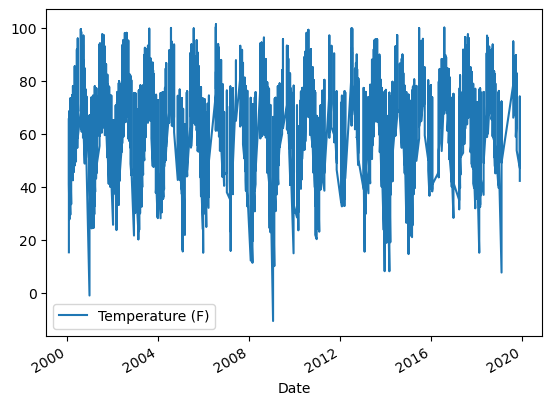

In [523]:
date_temp_df.plot('Date', 'Temperature (F)')

/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/1740114584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_temp_df['Date'] = pd.to_datetime(date_temp_df['Date'])


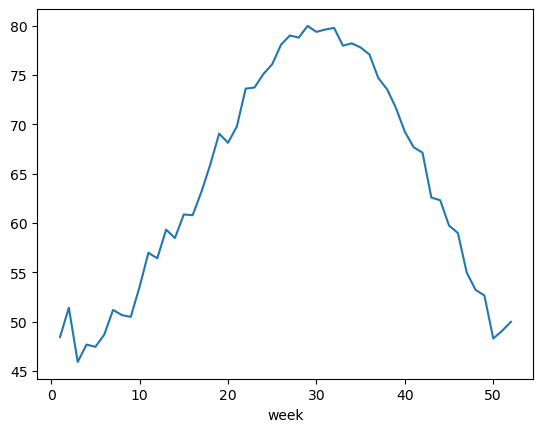

In [524]:
date_temp_df['Date'] = pd.to_datetime(date_temp_df['Date'])
date_temp_df.set_index('Date', inplace=True)
average_date_temp_df = date_temp_df["Temperature (F)"].groupby(by=date_temp_df.index.isocalendar().week).mean().plot()

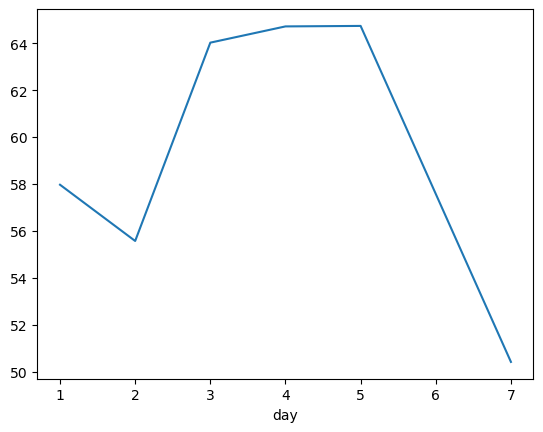

In [525]:
average_date_temp_df = date_temp_df["Temperature (F)"].groupby(by=date_temp_df.index.isocalendar().day).mean().plot()

In [526]:
print(date_rev_df['Revenue'].isnull().sum())

0


<Axes: xlabel='Date'>

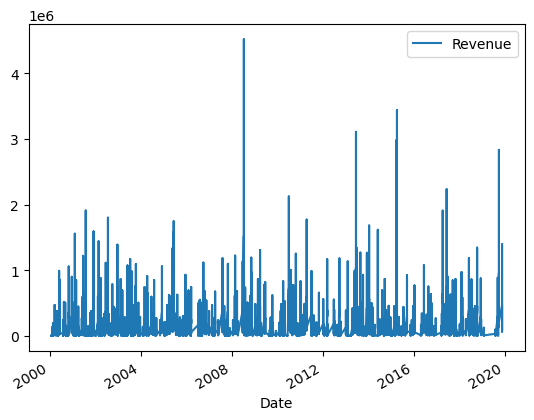

In [527]:
date_rev_df.plot('Date', 'Revenue')

In [528]:
date_rev_df_sorted = date_rev_df.sort_values(by='Revenue', ascending=False)
date_rev_df_sorted

,Date,Revenue
1383,2008-07-16,4519733.43
2349,2015-04-09,3439996.14
2048,2013-06-20,3110241.26
2342,2015-04-01,2983027.84
2825,2019-10-02,2834676.20
...,...,...
398,2001-11-21,17.20
500,2002-04-23,15.89
654,2003-04-09,13.40
1837,2011-07-15,11.07


In [529]:
movies_2008_07_16 = rename_clean_movies_cities_df[rename_clean_movies_cities_df['Date'] == '2008-07-16']
movies_2008_07_16

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Date,Miami,Chicago,Houston,Phoenix,Los Angeles,New York,Seattle
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,215778.26,1525973.28,1168082.04,828165.23,2097086.0,4519733.43,342350.63


In [530]:
rename_clean_movies_cities_sorted_by_revenue = rename_clean_movies_cities_df.sort_values(by='Domestic Revenue ($)', ascending=False)
rename_clean_movies_cities_sorted_by_revenue 

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Date,Miami,Chicago,Houston,Phoenix,Los Angeles,New York,Seattle
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,215778.26,1525973.28,1168082.04,828165.23,2097086.00,4519733.43,342350.63
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,148487.18,1050094.03,803812.22,569899.47,1443103.56,3110241.26,235587.58
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,142413.83,1007143.64,770935.12,546589.74,1384078.51,2983027.84,225951.70
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,135571.15,958752.49,733893.30,520327.25,1317576.43,2839699.58,215095.20
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,135331.32,957056.48,732595.06,519406.80,1315245.66,2834676.20,214714.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,21.58,152.58,116.80,82.81,209.69,451.93,34.23
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,19.73,139.55,106.82,75.74,191.78,413.33,31.31
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,15.89,112.36,86.00,60.98,154.41,332.78,25.21
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,11.07,78.30,59.94,42.50,107.61,231.92,17.57


#### 'The Dark Knight' was released on Wednesday, July 16th 2008. The film generated the most revenue of $535,234,033 domestically. 

In [531]:
rename_clean_movies_cities_sorted_by_movie = rename_clean_movies_cities_df.sort_values(by='Movie Title', ascending=True)
rename_clean_movies_cities_sorted_by_movie.head(50)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Date,Miami,Chicago,Houston,Phoenix,Los Angeles,New York,Seattle
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,21.58,152.58,116.80,82.81,209.69,451.93,34.23
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,9845.14,69624.34,53295.13,37786.02,95682.04,206218.21,15620.15
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,51298.18,362778.20,277694.70,196884.37,498552.03,1074501.61,81388.94
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,32742.17,231551.03,177244.65,125665.71,318211.61,685823.88,51948.25
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,6572.08,46477.40,35576.91,25223.88,63872.09,137659.99,10427.16
5,21 Jump Street,138447667,Action,Jonah Hill,Channing Tatum,R,2012-03-15,55854.03,394996.93,302357.07,214369.89,542828.98,1169929.27,88617.18
6,22 Jump Street,191719337,Action,Channing Tatum,Jonah Hill,R,2014-06-05,77345.45,546983.21,418697.54,296854.79,751697.84,1620092.77,122715.15
7,30 Minutes or Less,37053924,Action,Jesse Eisenberg,Danny McBride,R,2011-08-11,14948.69,105716.38,80922.39,57373.63,145281.93,313118.10,23717.37
8,3000 Miles to Graceland,15749959,Action,Kurt Russell,Kevin Costner,R,2001-02-23,6349.45,44902.97,34371.74,24369.42,61708.41,132996.72,10073.94
9,3:10 to Yuma,53606916,Action,Russell Crowe,Christian Bale,R,2007-09-06,21626.67,152942.75,117072.61,83003.99,210183.30,452996.44,34312.56


In [532]:
date_rev_df = rename_rev_date_temp_df[['Date', 'Revenue']]
date_rev_df

,Date,Revenue
0,2000-01-26,1804.69
1,2000-01-26,1381.43
2,2000-01-26,2480.11
3,2000-01-26,255.19
4,2000-01-26,5345.24
...,...,...
2830,2019-11-21,648346.54
2831,2019-11-21,66711.18
2832,2019-11-21,1397345.41
2833,2019-11-21,256040.07


In [533]:
rename_rev_date_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2835 non-null   datetime64[ns]
 1   City                 2835 non-null   object        
 2   Revenue              2835 non-null   float64       
 3   Temperature (F)      2835 non-null   float64       
 4   Weather Description  2835 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 110.9+ KB


/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/1268605162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_rev_df['Date'] = pd.to_datetime(date_rev_df['Date'])


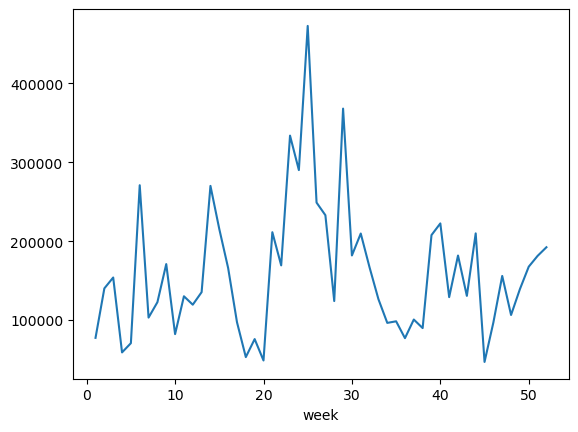

In [534]:
date_rev_df['Date'] = pd.to_datetime(date_rev_df['Date'])
date_rev_df.set_index('Date', inplace=True)
average_date_rev_df = date_rev_df["Revenue"].groupby(by=date_rev_df.index.isocalendar().week).mean().plot()

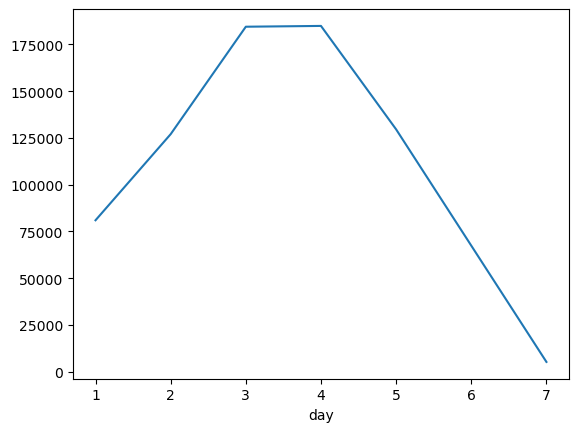

In [535]:
average_date_rev_df = date_rev_df["Revenue"].groupby(by=date_rev_df.index.isocalendar().day).mean().plot()

In [536]:
date_rev_df.reset_index(inplace=True)

In [537]:
clean_date_rev_df = date_rev_df.rename(columns={'Date':'ds', 'Revenue':'y'})
clean_date_rev_df

,ds,y
0,2000-01-26,1804.69
1,2000-01-26,1381.43
2,2000-01-26,2480.11
3,2000-01-26,255.19
4,2000-01-26,5345.24
...,...,...
2830,2019-11-21,648346.54
2831,2019-11-21,66711.18
2832,2019-11-21,1397345.41
2833,2019-11-21,256040.07


In [538]:
model_clean_date_rev = Prophet()


In [539]:
model_clean_date_rev.fit(clean_date_rev_df)



10:28:21 - cmdstanpy - INFO - Chain [1] start processing
10:28:22 - cmdstanpy - INFO - Chain [1] done processing


In [540]:
future_date_rev = model_clean_date_rev.make_future_dataframe(periods=2000, freq='H')
future_date_rev



/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
0,2000-01-26 00:00:00
1,2000-02-04 00:00:00
2,2000-02-18 00:00:00
3,2000-02-25 00:00:00
4,2000-03-03 00:00:00
...,...
2400,2020-02-12 04:00:00
2401,2020-02-12 05:00:00
2402,2020-02-12 06:00:00
2403,2020-02-12 07:00:00


In [541]:
forecast_date_rev = model_clean_date_rev.predict(future_date_temp)
forecast_date_rev



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-26 00:00:00,88823.157286,-246307.305624,486051.909461,88823.157286,88823.157286,11611.129369,11611.129369,11611.129369,66366.013968,66366.013968,66366.013968,-54754.884599,-54754.884599,-54754.884599,0.0,0.0,0.0,100434.286655
1,2000-02-04 00:00:00,88935.770013,-258178.622087,376032.005074,88935.770013,88935.770013,-18852.316059,-18852.316059,-18852.316059,25027.077170,25027.077170,25027.077170,-43879.393229,-43879.393229,-43879.393229,0.0,0.0,0.0,70083.453954
2,2000-02-18 00:00:00,89110.945366,-228289.532324,464863.197549,89110.945366,89110.945366,35653.090423,35653.090423,35653.090423,25027.077170,25027.077170,25027.077170,10626.013253,10626.013253,10626.013253,0.0,0.0,0.0,124764.035788
3,2000-02-25 00:00:00,89198.533042,-208875.538523,478986.707137,89198.533042,89198.533042,32040.141710,32040.141710,32040.141710,25027.077170,25027.077170,25027.077170,7013.064540,7013.064540,7013.064540,0.0,0.0,0.0,121238.674752
4,2000-03-03 00:00:00,89286.120718,-283324.459400,425973.909527,89286.120718,89286.120718,-3878.805031,-3878.805031,-3878.805031,25027.077170,25027.077170,25027.077170,-28905.882201,-28905.882201,-28905.882201,0.0,0.0,0.0,85407.315687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,2020-02-12 04:00:00,124758.590541,-137385.460737,554544.010793,124754.914746,124763.071799,62920.388846,62920.388846,62920.388846,73531.356166,73531.356166,73531.356166,-10610.967320,-10610.967320,-10610.967320,0.0,0.0,0.0,187678.979387
2401,2020-02-12 05:00:00,124758.692457,-166321.867085,515846.145213,124755.009805,124763.177239,64690.961614,64690.961614,64690.961614,75112.086932,75112.086932,75112.086932,-10421.125318,-10421.125318,-10421.125318,0.0,0.0,0.0,189449.654071
2402,2020-02-12 06:00:00,124758.794373,-156937.527494,524434.830027,124755.104864,124763.282678,66333.970452,66333.970452,66333.970452,76565.465413,76565.465413,76565.465413,-10231.494961,-10231.494961,-10231.494961,0.0,0.0,0.0,191092.764825
2403,2020-02-12 07:00:00,124758.896290,-167182.550705,562295.646496,124755.199922,124763.388118,67829.928313,67829.928313,67829.928313,77872.011918,77872.011918,77872.011918,-10042.083605,-10042.083605,-10042.083605,0.0,0.0,0.0,192588.824602


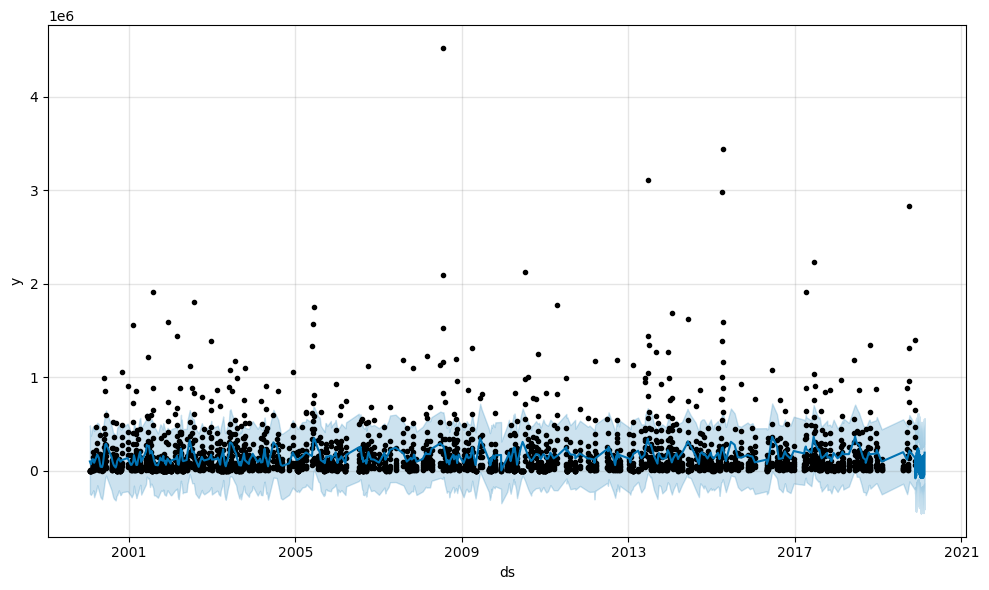

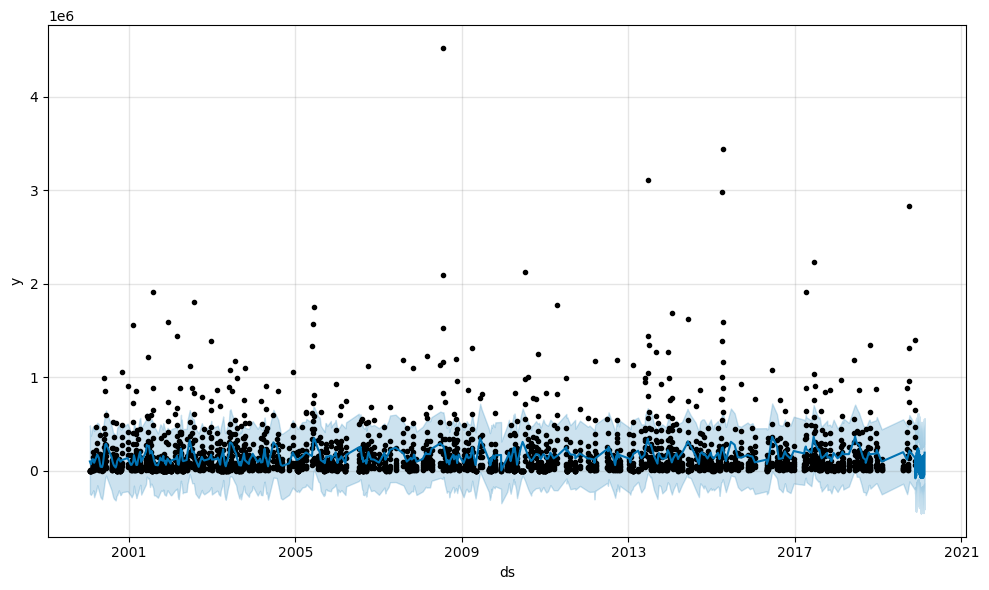

In [542]:
model_clean_date_rev.plot(forecast_date_rev)



In [543]:
forecast_date_rev = forecast_date_rev.set_index('ds')
forecast_date_rev[['yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
ds,,,
2000-01-26 00:00:00,100434.286655,-246307.305624,486051.909461
2000-02-04 00:00:00,70083.453954,-258178.622087,376032.005074
2000-02-18 00:00:00,124764.035788,-228289.532324,464863.197549
2000-02-25 00:00:00,121238.674752,-208875.538523,478986.707137
2000-03-03 00:00:00,85407.315687,-283324.459400,425973.909527
...,...,...,...
2020-02-12 04:00:00,187678.979387,-137385.460737,554544.010793
2020-02-12 05:00:00,189449.654071,-166321.867085,515846.145213
2020-02-12 06:00:00,191092.764825,-156937.527494,524434.830027


<Axes: xlabel='ds'>

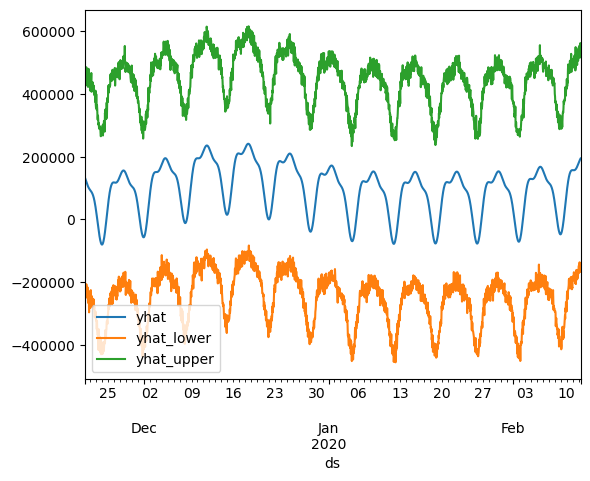

In [544]:
forecast_date_rev[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:,:].plot()



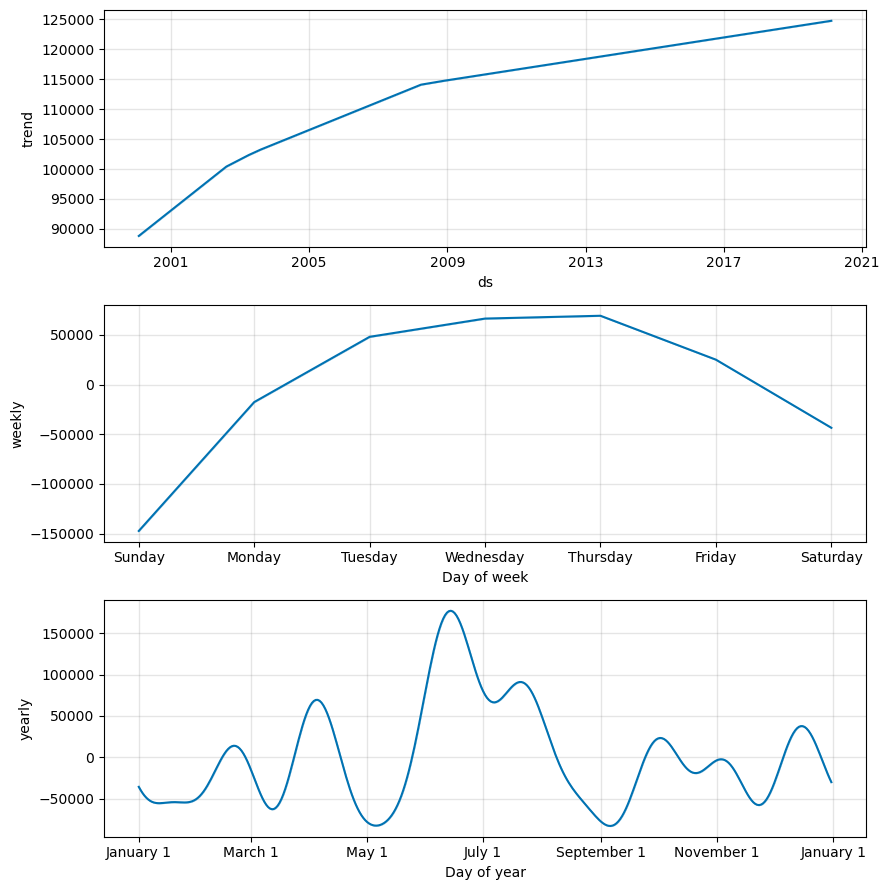

In [545]:
forecast_date_rev = forecast_date_rev.reset_index()
fig_forecast_date_rev = model_clean_date_rev.plot_components(forecast_date_rev)

### On average, theatres generate the most revenue around late June and on Thursdays.

In [546]:
date_temp_rev_corr_matrix = date_temp_rev_df.corr()
date_temp_rev_corr_matrix

,Temperature (F),Revenue
Temperature (F),1.0000,-0.0549
Revenue,-0.0549,1.0000


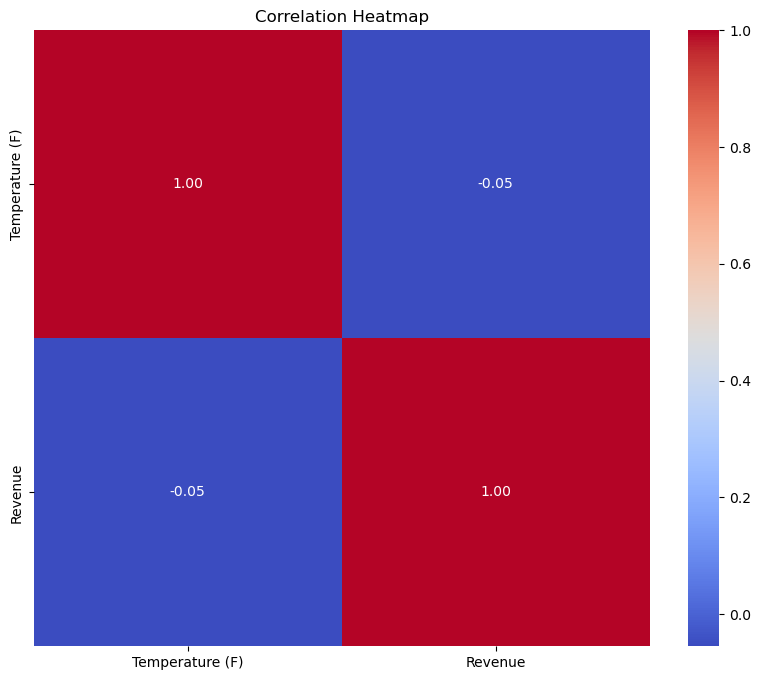

In [547]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(date_temp_rev_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

### There is very little correlation between revenue and temperature because the values outside the primary diagonal are close to zero. 

In [548]:
merged_movies_weather_df = pd.read_csv('Resources/merge_movies_weather.csv')

In [549]:
merged_movies_weather_df.head(20)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,"$9,845.14","$69,624.34","$53,295.13",...,38.049091,58.111667,46.157083,haze,light rain,overcast clouds,few clouds,overcast clouds,scattered clouds,broken clouds
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,"$51,298.18","$362,778.20","$277,694.70",...,59.534792,91.475833,64.324167,broken clouds,broken clouds,sky is clear,thunderstorm,mist,few clouds,sky is clear
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,"$32,742.17","$231,551.03","$177,244.65",...,44.876250,72.545833,38.504583,light rain and snow,broken clouds,sky is clear,scattered clouds,overcast clouds,few clouds,broken clouds
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,"$6,572.08","$46,477.40","$35,576.91",...,49.385833,62.507917,37.777500,scattered clouds,few clouds,sky is clear,scattered clouds,sky is clear,sky is clear,light rain
5,21 Jump Street,138447667,Action,Jonah Hill,Channing Tatum,R,2012-03-15,"$55,854.03","$394,996.93","$302,357.07",...,48.744167,67.797083,46.276667,sky is clear,scattered clouds,broken clouds,scattered clouds,sky is clear,few clouds,light rain
6,22 Jump Street,191719337,Action,Channing Tatum,Jonah Hill,R,2014-06-05,"$77,345.45","$546,983.21","$418,697.54",...,67.443529,92.252083,59.749167,broken clouds,sky is clear,sky is clear,broken clouds,broken clouds,few clouds,overcast clouds
7,30 Minutes or Less,37053924,Action,Jesse Eisenberg,Danny McBride,R,2011-08-11,"$14,948.69","$105,716.38","$80,922.39",...,75.663333,93.262083,62.543750,scattered clouds,sky is clear,sky is clear,overcast clouds,sky is clear,scattered clouds,scattered clouds
8,3000 Miles to Graceland,15749959,Action,Kurt Russell,Kevin Costner,R,2001-02-23,"$6,349.45","$44,902.97","$34,371.74",...,24.603846,58.750833,43.829583,overcast clouds,overcast clouds,overcast clouds,scattered clouds,fog,scattered clouds,scattered clouds
9,3:10 to Yuma,53606916,Action,Russell Crowe,Christian Bale,R,2007-09-06,"$21,626.67","$152,942.75","$117,072.61",...,72.271667,91.730417,63.368333,broken clouds,broken clouds,sky is clear,scattered clouds,few clouds,scattered clouds,broken clouds


In [550]:
#create a dataframe of the top ten highest grossing films between 2000-2020
highest_grossing_movies_df = merged_movies_weather_df.sort_values(by='Domestic Revenue ($)', ascending=False)
highest_grossing_movies_df.head(20)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [551]:
#store the top ten grossing movies in a dataframe
top_twenty_movies_df = highest_grossing_movies_df.head(20)
top_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [552]:
top_twenty_movies_df = top_twenty_movies_df.dropna()
top_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,Christian Bale,Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,Steve Carell,Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,Vin Diesel,Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,Sandra Bullock,Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,Joaquin Phoenix,Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,Steve Carell,Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,Steve Carell,Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,Jackie Chan,Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,Vin Diesel,Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,Mike Myers,Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [553]:
#create a dataframe of the lowest grossing films between 2000-2020
lowest_grossing_movies_df = merged_movies_weather_df.sort_values(by='Domestic Revenue ($)', ascending=True)
lowest_grossing_movies_df.head(20)

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


In [554]:
#save lowest_grossing_movies_df to a dataframe
bottom_twenty_movies_df = lowest_grossing_movies_df.head(20)
bottom_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


In [555]:
bottom_twenty_movies_df = bottom_twenty_movies_df.dropna()
bottom_twenty_movies_df

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
294,Shade,25032,Crime,Joe Nicolo,Carl Mazzocone Sr.,R,2003-04-09,$13.40,$94.79,$72.56,...,37.065652,76.022917,49.618750,overcast clouds,sky is clear,sky is clear,scattered clouds,overcast clouds,sky is clear,overcast clouds
284,Salvation Boulevard,28468,Action,Greg Kinnear,Pierce Brosnan,R,2011-07-15,$11.07,$78.30,$59.94,...,73.241250,88.893333,60.647917,broken clouds,light rain,overcast clouds,overcast clouds,sky is clear,sky is clear,overcast clouds
84,Close Your Eyes,41392,Crime,Goran Visnjic,Paddy Considine,R,2002-04-23,$15.89,$112.36,$86.00,...,46.684615,77.042500,45.509167,overcast clouds,broken clouds,sky is clear,scattered clouds,mist,scattered clouds,light rain
211,Mini's First Time,49034,Comedy,Alec Baldwin,Nikki Reed,R,2006-07-14,$19.73,$139.55,$106.82,...,77.016250,101.378333,61.513333,scattered clouds,scattered clouds,sky is clear,scattered clouds,overcast clouds,few clouds,overcast clouds
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,74.710000,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear
192,Leaves of Grass,70066,Comedy,Edward Norton,Keri Russell,R,2009-09-17,$27.44,$194.03,$148.53,...,60.302500,86.283750,61.151667,few clouds,few clouds,sky is clear,light rain,light rain,few clouds,overcast clouds
122,Eye See You,79161,Crime,Sylvester Stallone,Charles S. Dutton,R,2002-01-04,$31.94,$225.85,$172.88,...,31.957083,53.573333,46.543750,sky is clear,sky is clear,sky is clear,few clouds,few clouds,overcast clouds,scattered clouds
440,Wild Target,108589,Action,Bill Nighy,Emily Blunt,PG-13,2010-06-18,$47.28,$334.35,$255.93,...,71.865833,91.058750,57.184583,scattered clouds,sky is clear,sky is clear,light rain,overcast clouds,sky is clear,broken clouds
418,Trust,120016,Crime,Clive Owen,Catherine Keener,R,2010-04-01,$48.42,$342.41,$262.10,...,55.727083,65.100417,44.845417,broken clouds,broken clouds,sky is clear,sky is clear,few clouds,scattered clouds,broken clouds
66,Bubble,145626,Crime,Debbie Doebereiner,Omar Cowan,R,2005-01-27,$58.65,$414.78,$317.50,...,15.715000,57.668333,48.070417,light snow,broken clouds,light rain,sky is clear,overcast clouds,light rain,light rain


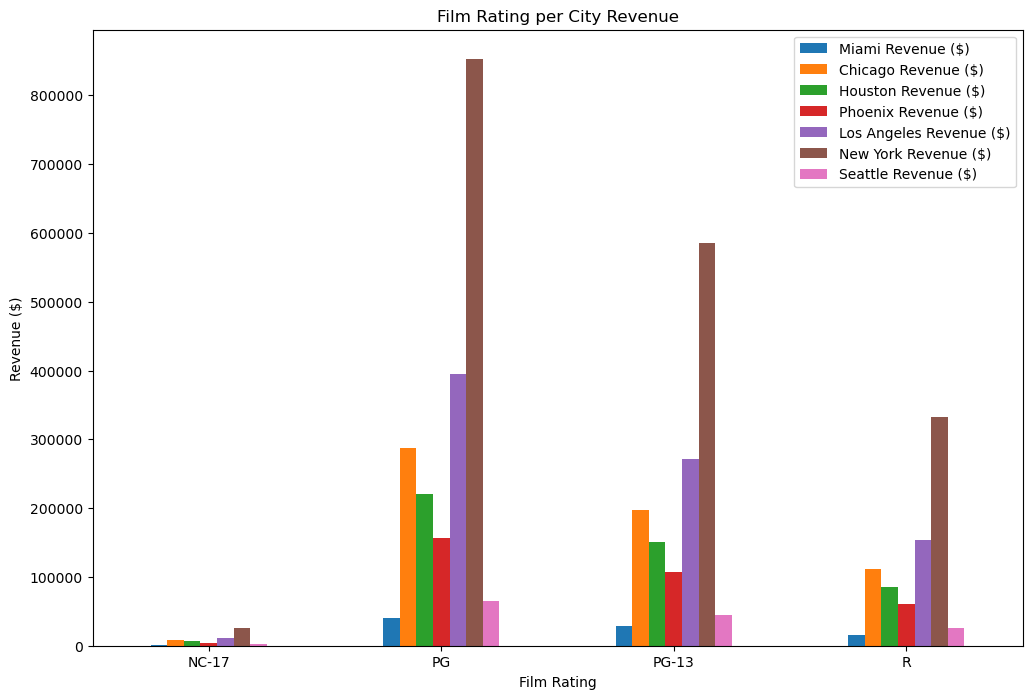

In [556]:
# Convert revenue columns to numeric values
revenue_columns = ['Miami Revenue ($)', 'Chicago Revenue ($)', 'Houston Revenue ($)', 
                'Phoenix Revenue ($)', 'Los Angeles Revenue ($)', 'New York Revenue ($)', 'Seattle Revenue ($)']
for col in ['Miami Revenue ($)', 'Chicago Revenue ($)', 'Houston Revenue ($)', 'Phoenix Revenue ($)', 'Los Angeles Revenue ($)', 
            'New York Revenue ($)', 'Seattle Revenue ($)']:
    clean_movies_cities_df.loc[:, col] = clean_movies_cities_df[col].replace('[$,]', '', regex=True).astype(float)

# Group by Film Rating and calculate the sum of revenues for each rating
grouped_revenue_by_rating = clean_movies_cities_df.groupby('Film Rating')[revenue_columns].mean()

# Display the result
grouped_revenue_by_rating
# Plot the Film Rating per city revenue
grouped_revenue_by_rating.plot(kind='bar', figsize=(12, 8))

# Set the title and labels
plt.title('Film Rating per City Revenue')
plt.xlabel('Film Rating')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=0)

# Display the plot
plt.show()


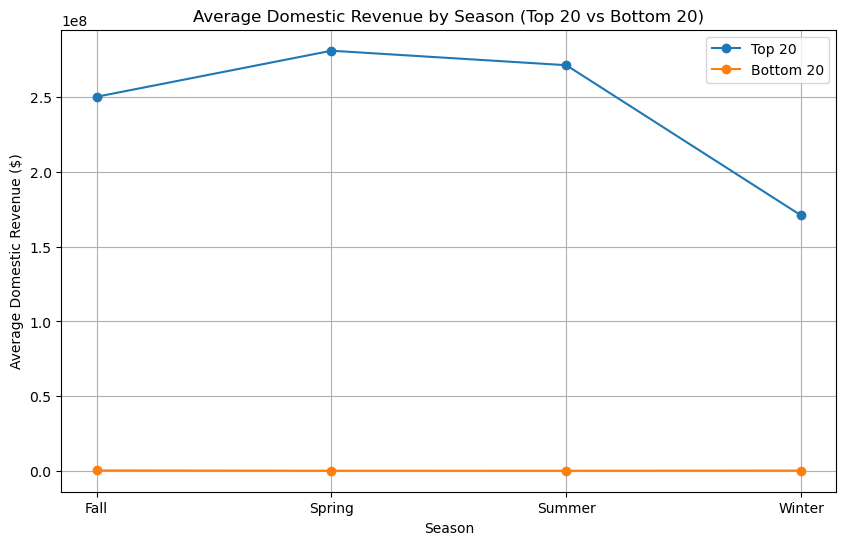

In [557]:
# Assuming you have top_twenty_movies_df and bottom_twenty_movies_df with 'Release Date' and 'Domestic Revenue ($)' columns

# 1. Function to determine the season based on the month (same as before)
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# 2. Function to process a DataFrame and get seasonal revenue
def get_seasonal_revenue(df):
    df['Release Date'] = pd.to_datetime(df['Release Date'])  # Convert to datetime
    df['Season'] = df['Release Date'].apply(get_season)  # Add 'Season' column
    seasonal_revenue = df.groupby('Season')['Domestic Revenue ($)'].mean().reset_index()  # Calculate average revenue
    return seasonal_revenue

# 3. Get seasonal revenue for top and bottom 20 movies
top_seasonal_revenue = get_seasonal_revenue(top_twenty_movies_df.copy())  # Use copy to avoid modifying original DataFrame
bottom_seasonal_revenue = get_seasonal_revenue(bottom_twenty_movies_df.copy())

# 4. Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(top_seasonal_revenue['Season'], top_seasonal_revenue['Domestic Revenue ($)'], marker='o', label='Top 20')
plt.plot(bottom_seasonal_revenue['Season'], bottom_seasonal_revenue['Domestic Revenue ($)'], marker='o', label='Bottom 20')
plt.xlabel('Season')
plt.ylabel('Average Domestic Revenue ($)')
plt.title('Average Domestic Revenue by Season (Top 20 vs Bottom 20)')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Season'>

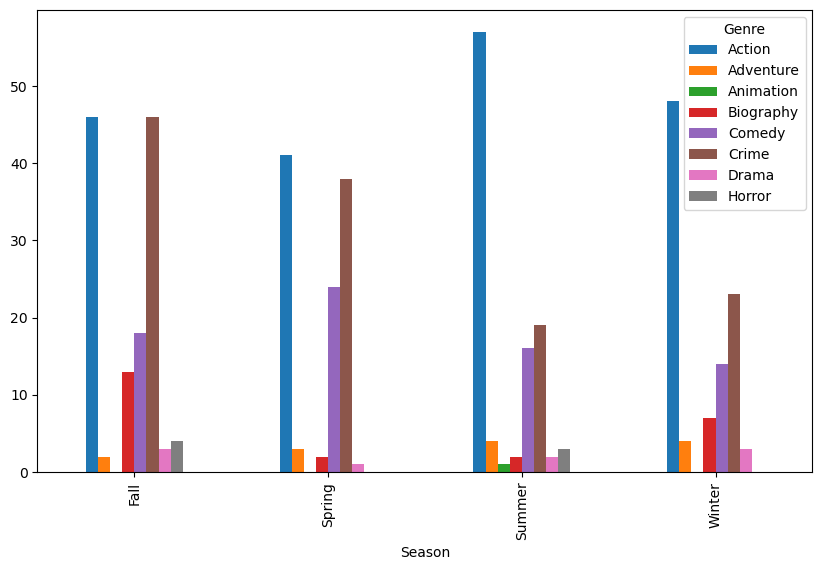

In [558]:
import pandas as pd

# Assuming 'Release Date' column is in datetime format:
merged_movies_weather_df['Release Date'] = pd.to_datetime(merged_movies_weather_df['Release Date'])
# If it's not, you need to convert it to datetime format first.

# Function to extract season from date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a 'Season' column
merged_movies_weather_df['Season'] = merged_movies_weather_df['Release Date'].apply(get_season)

# Group by 'Season' and 'Genre' and count occurrences
genre_frequency_by_season = merged_movies_weather_df.groupby(['Season', 'Genre'])['Genre'].count().unstack()

# Plot the results
genre_frequency_by_season.plot(kind='bar', figsize=(10, 6))

In [559]:
import pandas as pd

# Assuming 'Release Date' column is in datetime format:
merged_movies_weather_df['Release Date'] = pd.to_datetime(merged_movies_weather_df['Release Date'])
# If it's not, you need to convert it to datetime format first.

# Function to extract season from date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a 'Season' column
merged_movies_weather_df['Season'] = merged_movies_weather_df['Release Date'].apply(get_season)

# Group by 'Season' and get the maximum 'Domestic Revenue ($)'
highest_revenue_by_season = merged_movies_weather_df.groupby('Season')['Domestic Revenue ($)'].max()
highest_revenue_by_season



Season
Fall      335451311
Spring    353007020
Summer    535234033
Winter    204417855
Name: Domestic Revenue ($), dtype: int64

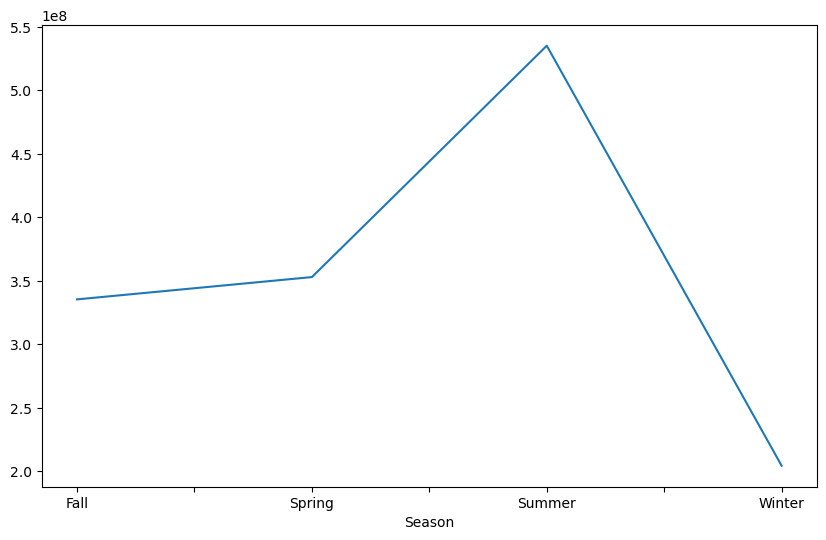

In [560]:
# Plot the results
highest_revenue_by_season.plot(kind='line', figsize=(10, 6))
x_labels = ['Spring', 'Summer', 'Fall', 'Winter']

y_labels = [f'${value:,.0f}' for value in highest_revenue_by_season]

In [561]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(merged_movies_weather_df['Genre'], merged_movies_weather_df['Season'])

# Perform the chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {dof}")

# Interpret the results
alpha = 0.05  # Significance level
if p_val < alpha:
    print("There is a statistically significant association between genre and season.")
else:
    print("There is no statistically significant association between genre and season.")



Chi-squared statistic: 40.64482538485163
P-value: 0.006202071201625172
Degrees of freedom: 21
There is a statistically significant association between genre and season.


In [562]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table (cross-tabulation)
revenue_contingency_table = pd.crosstab(merged_movies_weather_df['Domestic Revenue ($)'], merged_movies_weather_df['Season'])

# Perform the chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {dof}")

# Interpret the results
alpha = 0.05  # Significance level
if p_val < alpha:
    print("There is a statistically significant association between revenue and season.")
else:
    print("There is no statistically significant association between revenue and season.")

Chi-squared statistic: 40.64482538485163
P-value: 0.006202071201625172
Degrees of freedom: 21
There is a statistically significant association between revenue and season.


In [563]:
#calulate the frequency of each genre in cleaned_movies_citiies_df
genre_counts = merged_movies_weather_df['Genre'].value_counts()
print(genre_counts)

Genre
Action       192
Crime        126
Comedy        72
Biography     24
Adventure     13
Drama          9
Horror         7
Animation      1
Name: count, dtype: int64


In [564]:
#save genre counts in a dataframe
genre_counts_df = pd.DataFrame(genre_counts)
genre_counts_df

,count
Genre,
Action,192
Crime,126
Comedy,72
Biography,24
Adventure,13
Drama,9
Horror,7
Animation,1


In [565]:
# correlate leading actor and domestic revenue in 'merge_movies_weather_df'
actor_revenue_corr = top_twenty_movies_df['Leading Actor'].str.get_dummies(sep=', ').corrwith(top_twenty_movies_df['Domestic Revenue ($)'])
actor_revenue_corr_df = pd.DataFrame(actor_revenue_corr)
actor_revenue_corr_df

,0
Anthony Hopkins,-0.214145
Brad Pitt,-0.160677
Channing Tatum,-0.147128
Christian Bale,0.442688
Daniel Craig,-0.213463
George Clooney,-0.168024
Jackie Chan,-0.060435
Joaquin Phoenix,0.214628
Leonardo DiCaprio,-0.215346
Mike Myers,-0.092793


In [566]:
# For top_twenty_movies_df, split the 'Actors' column into a list of individual actors
# Ensure the 'Leading Actor' column contains strings before using .str
top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')
top_twenty_movies_df

/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/1352114251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')


,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,New York Temperature,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description
335,The Dark Knight,535234033,Action,[Christian Bale],Heath Ledger,PG-13,2008-07-16,"$215,778.26","$1,525,973.28","$1,168,082.04",...,79.475000,94.502917,65.746250,few clouds,broken clouds,sky is clear,overcast clouds,few clouds,scattered clouds,sky is clear
105,Despicable Me 2,368065385,Adventure,[Steve Carell],Kristen Wiig,PG,2013-06-20,"$148,487.18","$1,050,094.03","$803,812.22",...,70.077083,91.895833,58.993750,few clouds,thunderstorm with light rain,sky is clear,light rain,sky is clear,few clouds,overcast clouds
137,Furious 7,353007020,Action,[Vin Diesel],Paul Walker,PG-13,2015-04-01,"$142,413.83","$1,007,143.64","$770,935.12",...,39.411600,80.557917,46.624167,few clouds,sky is clear,sky is clear,few clouds,light rain,few clouds,moderate rain
212,Minions,336045770,Adventure,[Sandra Bullock],Jon Hamm,PG,2015-04-09,"$135,571.15","$958,752.49","$733,893.30",...,39.763667,66.670833,51.047083,overcast clouds,broken clouds,sky is clear,broken clouds,overcast clouds,sky is clear,scattered clouds
177,Joker,335451311,Crime,[Joaquin Phoenix],Robert De Niro,R,2019-10-02,"$135,331.32","$957,056.48","$732,595.06",...,78.680800,77.834583,53.772083,broken clouds,sky is clear,sky is clear,light rain,sky is clear,smoke,sky is clear
106,Despicable Me 3,264624300,Adventure,[Steve Carell],Kristen Wiig,PG,2017-06-14,"$106,757.54","$754,984.08","$577,915.33",...,77.311111,85.319167,56.168333,broken clouds,few clouds,sky is clear,overcast clouds,sky is clear,sky is clear,overcast clouds
104,Despicable Me,251513985,Animation,[Steve Carell],Jason Segel,PG,2010-07-08,"$101,468.44","$717,579.81","$549,283.59",...,80.411600,98.155000,71.681667,broken clouds,mist,sky is clear,light rain,sky is clear,scattered clouds,sky is clear
281,Rush Hour 2,226164286,Action,[Jackie Chan],Chris Tucker,PG-13,2001-08-03,"$91,241.59","$645,256.07","$493,922.16",...,78.879167,97.392500,63.078333,broken clouds,broken clouds,sky is clear,overcast clouds,scattered clouds,scattered clouds,broken clouds
344,The Fate of the Furious,226008385,Action,[Vin Diesel],Jason Statham,PG-13,2017-04-12,"$91,178.70","$644,811.28","$493,581.69",...,64.492917,75.345833,51.186667,broken clouds,light rain,sky is clear,few clouds,sky is clear,broken clouds,overcast clouds
31,Austin Powers in Goldmember,213307889,Action,[Mike Myers],Beyoncé,PG-13,2002-07-26,"$86,054.93","$608,576.24","$465,844.97",...,67.941667,97.064167,64.450417,broken clouds,broken clouds,sky is clear,scattered clouds,scattered clouds,scattered clouds,scattered clouds


In [567]:
# Create a new DataFrame with one-hot encoded actors
actors_df = pd.get_dummies(top_twenty_movies_df['Leading Actor'].apply(pd.Series).stack()).groupby(level=0).sum()

In [568]:
# Reset index of actors_df to match clean_movies_cities_df
actors_df = actors_df.reset_index(drop=True)

In [569]:
# 2. Concatenate with revenue
# Concatenate the one-hot encoded actors with the revenue column
correlation_df = pd.concat([top_twenty_movies_df['Domestic Revenue ($)'], actors_df], axis=1)

In [570]:
# 3. Calculate correlation
# Calculate the correlation between each actor and revenue
actor_correlations = correlation_df.corr()['Domestic Revenue ($)'].drop('Domestic Revenue ($)')

In [571]:
for actor, correlation in actor_revenue_corr.items():
    print(f"Correlation between {actor} and Domestic Revenue: {correlation:.2f}")


Correlation between Anthony Hopkins and Domestic Revenue: -0.21
Correlation between Brad Pitt and Domestic Revenue: -0.16
Correlation between Channing Tatum and Domestic Revenue: -0.15
Correlation between Christian Bale and Domestic Revenue: 0.44
Correlation between Daniel Craig and Domestic Revenue: -0.21
Correlation between George Clooney and Domestic Revenue: -0.17
Correlation between Jackie Chan and Domestic Revenue: -0.06
Correlation between Joaquin Phoenix and Domestic Revenue: 0.21
Correlation between Leonardo DiCaprio and Domestic Revenue: -0.22
Correlation between Mike Myers and Domestic Revenue: -0.09
Correlation between Renée Zellweger and Domestic Revenue: -0.20
Correlation between Sandra Bullock and Domestic Revenue: 0.22
Correlation between Steve Carell and Domestic Revenue: 0.21
Correlation between Vin Diesel and Domestic Revenue: 0.06


In [572]:
# For top_twenty_movies_df, split the 'Actors' column into a list of individual actors
# Ensure the 'Leading Actor' column contains strings before using .str
top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')

# Create a new DataFrame with one-hot encoded actors
actors_df = pd.get_dummies(top_twenty_movies_df['Leading Actor'].apply(pd.Series).stack()).groupby(level=0).sum()

# Reset index of actors_df to match clean_movies_cities_df
actors_df = actors_df.reset_index(drop=True)

# 2. Concatenate with revenue
# Concatenate the one-hot encoded actors with the revenue column
correlation_df = pd.concat([top_twenty_movies_df['Domestic Revenue ($)'], actors_df], axis=1)


# 3. Calculate correlation
# Calculate the correlation between each actor and revenue
actor_correlations = correlation_df.corr()['Domestic Revenue ($)'].drop('Domestic Revenue ($)')



/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/2575946228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_twenty_movies_df['Leading Actor'] = top_twenty_movies_df['Leading Actor'].astype(str).str.split(', ')


In [573]:
actor_revenue_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Anthony Hopkins to Vin Diesel
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14 non-null     float64
dtypes: float64(1)
memory usage: 224.0+ bytes


In [574]:
# Convert the Series to a DataFrame for easier manipulation
actor_correlations_df = pd.DataFrame({'Correlation': actor_revenue_corr})

# Sort the DataFrame by 'Correlation' in descending order and get the top 20
top_20_correlations_df = actor_correlations_df.sort_values(by=['Correlation'], ascending=False).head(20) # Change this line

#save the top 20 correlations to a dataframe
top_20_correlations_df = pd.DataFrame(top_20_correlations_df) # Change this line

# Now top_20_correlations_df contains the top 20 correlations
#print(top_20_correlations_df)


In [575]:
actor_correlations_df.count()

Correlation    14
dtype: int64

In [576]:
#review top_20_correlations dataframe
actor_correlations_df

,Correlation
Anthony Hopkins,-0.214145
Brad Pitt,-0.160677
Channing Tatum,-0.147128
Christian Bale,0.442688
Daniel Craig,-0.213463
George Clooney,-0.168024
Jackie Chan,-0.060435
Joaquin Phoenix,0.214628
Leonardo DiCaprio,-0.215346
Mike Myers,-0.092793


/var/folders/ts/dsv00vbn2ygg_1mgkl5xxg_c0000gn/T/ipykernel_2138/2399402690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y=top_20_correlations_df.index, data=top_20_correlations_df, palette='coolwarm')


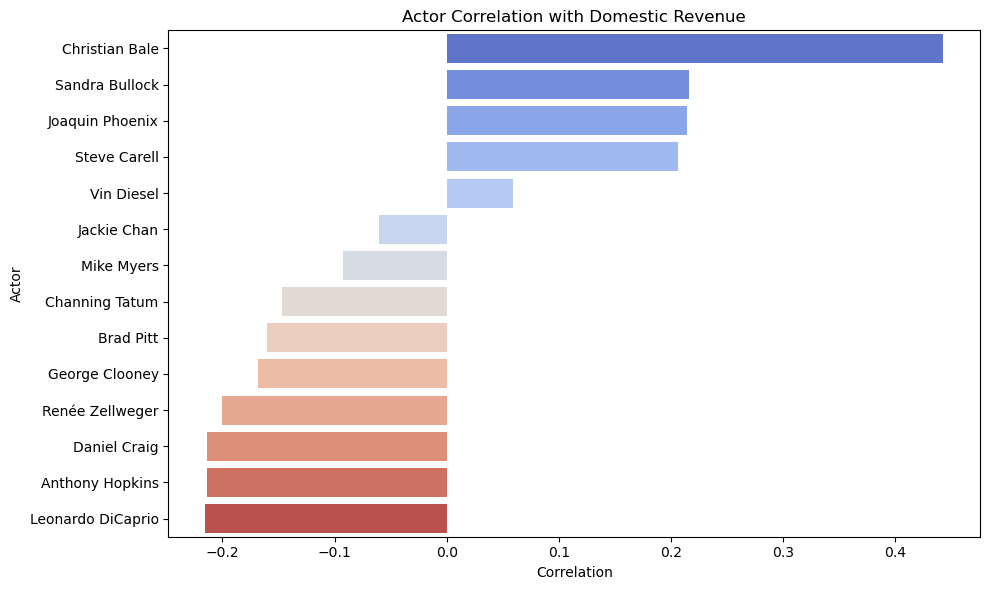

In [577]:

# Create a new DataFrame from actor_revenue_corr, avoiding overwriting the original Series
top_20_correlations_df = pd.DataFrame({'Correlation': actor_revenue_corr}) 

# Sort the DataFrame by 'Correlation' in descending order
top_20_correlations_df = top_20_correlations_df.sort_values(by=['Correlation'], ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y=top_20_correlations_df.index, data=top_20_correlations_df, palette='coolwarm')

plt.title('Actor Correlation with Domestic Revenue')
plt.xlabel('Correlation')
plt.ylabel('Actor')
plt.tight_layout()
plt.show()

In [578]:
merge_movies_weather_df = merged_movies_weather_df.dropna()
merge_movies_weather_df.head()

,Movie Title,Domestic Revenue ($),Genre,Leading Actor,Supporting Actor,Film Rating,Release Date,Miami Revenue ($),Chicago Revenue ($),Houston Revenue ($),...,Phoenix Temperature,Seattle Temperature,Chicago Weather Description,Houston Weather Description,Los Angeles Weather Description,Miami Weather Description,New York Weather Description,Phoenix Weather Description,Seattle Weather Description,Season
0,10th & Wolf,54702,Crime,James Marsden,Giovanni Ribisi,R,2006-08-18,$21.58,$152.58,$116.80,...,93.972500,63.559583,overcast clouds,light rain,sky is clear,scattered clouds,sky is clear,scattered clouds,sky is clear,Summer
1,15 Minutes,24403552,Action,Robert De Niro,Edward Burns,R,2001-03-09,"$9,845.14","$69,624.34","$53,295.13",...,58.111667,46.157083,haze,light rain,overcast clouds,few clouds,overcast clouds,scattered clouds,broken clouds,Spring
2,2 Fast 2 Furious,127154901,Action,Paul Walker,Tyrese Gibson,PG-13,2003-06-05,"$51,298.18","$362,778.20","$277,694.70",...,91.475833,64.324167,broken clouds,broken clouds,sky is clear,thunderstorm,mist,few clouds,sky is clear,Summer
3,21,81159365,Crime,Jim Sturgess,Kate Bosworth,PG-13,2008-03-28,"$32,742.17","$231,551.03","$177,244.65",...,72.545833,38.504583,light rain and snow,broken clouds,sky is clear,scattered clouds,overcast clouds,few clouds,broken clouds,Spring
4,21 Grams,16290476,Crime,Sean Penn,Benicio Del Toro,R,2003-11-21,"$6,572.08","$46,477.40","$35,576.91",...,62.507917,37.777500,scattered clouds,few clouds,sky is clear,scattered clouds,sky is clear,sky is clear,light rain,Fall


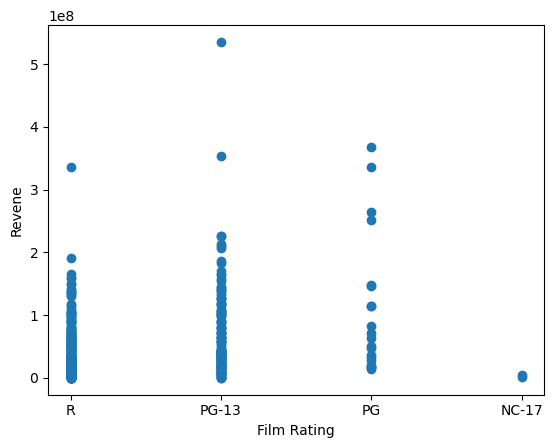

In [579]:
#Determine if Domestic Revenue and Genres are correlated.

plt.scatter(merge_movies_weather_df.iloc[:,5],merge_movies_weather_df.iloc[:,1])
plt.xlabel('Film Rating')
plt.ylabel('Revene')
plt.show()